# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [2]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [3]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [5]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [6]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

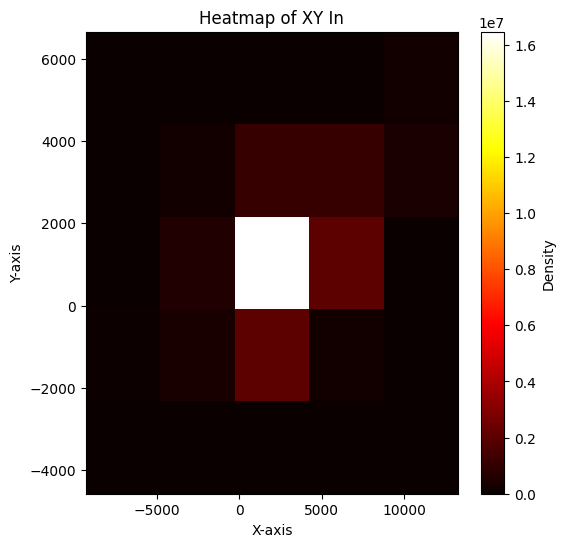

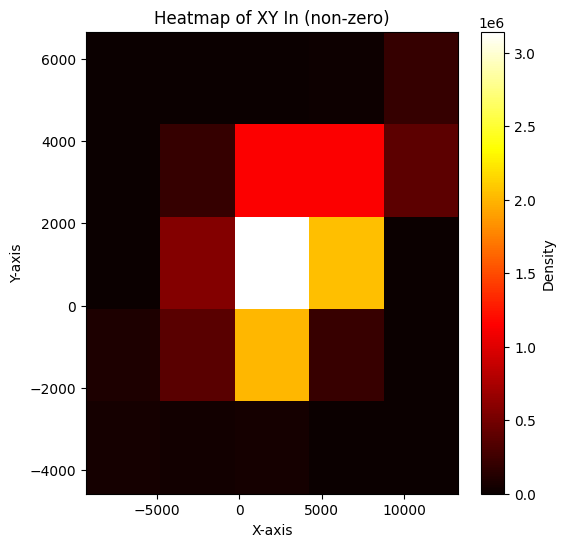

In [7]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

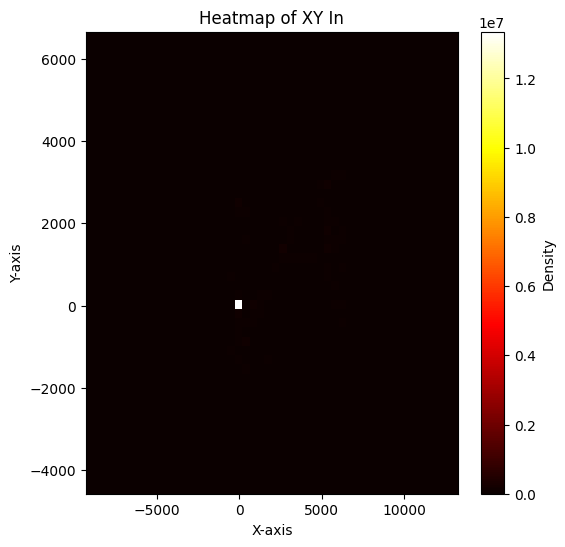

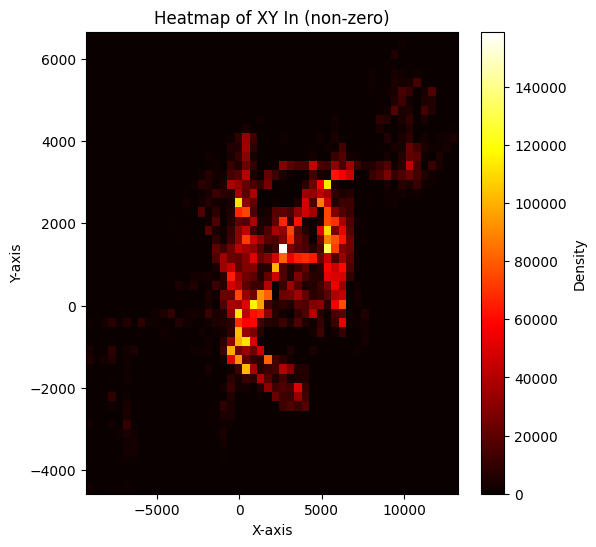

In [8]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [10]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
)
val_dataloader = DataLoader(
    val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
)

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

#### Your Model for Question 2 Problem B (Include your model architecture pictures and also can use some mathmatical equations to explain your model in your report)

In [11]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim=50 * 50 * 2, output_dim=60 * 2):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, data):
        x = data.x[..., :2] # (batch*50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 2) # (batch, 5000)
        x = self.linear(x)
        return x.view(-1, 60, 2)

In [12]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        
        # Define the layers
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(256, output_features)
        )
    
    def forward(self, data):
        x = data.x
        x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.mlp(x)
        return x.view(-1, 60, 2)

#### This Model will be covered during Week 6 Lecture (If you don't understand it for now, don't worry, we will cover it in the lecture, or you can ask in the office hours)

In [13]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

#### Trying Transformer Model

In [14]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim=6, model_dim=128, num_heads=4, num_layers=2, output_dim=60*2, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.input_proj = nn.Linear(input_dim, model_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(model_dim, output_dim)

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent index 0, shape: (batch, 50, 6)
        x = self.input_proj(x)  # (batch, 50, model_dim)
        x = self.transformer_encoder(x)  # (batch, 50, model_dim)
        out = self.fc(x[:, -1, :])  # Use last time step's output
        return out.view(-1, 60, 2)

In [15]:
class AdvancedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len
        self.input_proj = nn.Linear(input_dim, model_dim)
        
        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Decoder for future trajectory
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch, agents, seq, features)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        x = self.input_proj(x)  # (batch, seq, model_dim)
        x = x + self.pos_encoding[:, :self.seq_len, :]  # Add positional encoding
        x = self.encoder(x)  # (batch, seq, model_dim)
        x = x[:, -1, :]  # Use last time step's output (batch, model_dim)
        out = self.decoder(x)  # (batch, future_len*2)
        return out.view(-1, self.future_len, 2)

In [16]:
class BeefedTransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=6,
        model_dim=256,
        num_heads=8,
        num_layers=6,
        seq_len=50,
        future_len=60,
        dropout=0.15
    ):
        super().__init__()
        self.seq_len = seq_len
        self.future_len = future_len

        # Temporal convolution for local feature extraction
        self.temporal_conv = nn.Conv1d(input_dim, input_dim, kernel_size=3, padding=1, groups=input_dim)
        self.input_proj = nn.Linear(input_dim, model_dim)

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, seq_len, model_dim))

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=model_dim,
            nhead=num_heads,
            dim_feedforward=model_dim*6,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Deeper MLP decoder with residual connection
        self.decoder = nn.Sequential(
            nn.LayerNorm(model_dim),
            nn.Linear(model_dim, model_dim*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim*2, model_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(model_dim, future_len * 2)
        )

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)
        x = x[:, 0, :, :]  # Only ego agent: (batch, seq, features)
        # Temporal convolution
        x = x.transpose(1, 2)  # (batch, features, seq)
        x = self.temporal_conv(x)
        x = x.transpose(1, 2)  # (batch, seq, features)
        x = self.input_proj(x)
        x = x + self.pos_encoding[:, :self.seq_len, :]
        x = self.encoder(x)
        x = x[:, -1, :]  # Last time step
        out = self.decoder(x)
        return out.view(-1, self.future_len, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [17]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
# model = TransformerModel().to(device)
# model = AdvancedTransformerModel().to(device)
# model = AdvancedTransformerModel(
#     input_dim=6,
#     model_dim=512,      # 2x wider
#     num_heads=16,       # 2x more heads
#     num_layers=12,      # 2x deeper
#     seq_len=50,
#     future_len=60,
#     dropout=0.10        # Slightly higher dropout for regularization
# ).to(device)
# model = BeefedTransformerModel(
#     input_dim=6,
#     model_dim=1152,
#     num_heads=36,
#     num_layers=20,
#     seq_len=50,
#     future_len=60,
#     dropout=0.15
# ).to(device)
# model_dim=128, num_heads=4, num_layers=2


#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [20]:
from sklearn.model_selection import KFold

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
all_indices = np.arange(len(train_data))
fold_results = []

for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
    print(f"\n--- Fold {fold+1}/{k_folds} ---")

    # Create datasets for this fold
    train_dataset = TrajectoryDatasetTrain(train_data[train_idx], scale=scale, augment=True)
    val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
    train_dataloader = DataLoader(
        train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x)
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
    )
    
    model = TransformerModel(
        input_dim=6,
        model_dim=128,
        num_heads=4,
        num_layers=2,
        dropout=0.0
    ).to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
    early_stopping_patience = 20
    best_val_loss = float('inf')
    no_improvement = 0
    criterion = nn.MSELoss()

    for epoch in tqdm.tqdm(range(100), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            loss = criterion(pred, y)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            train_loss += loss.item()
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                val_loss += criterion(pred, y).item()

                # show MAE and MSE with unnormalized data
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                val_mae += nn.L1Loss()(pred, y).item()
                val_mse += nn.MSELoss()(pred, y).item()
        
        train_loss /= len(train_dataloader)
        val_loss /= len(val_dataloader)
        val_mae /= len(val_dataloader)
        val_mse /= len(val_dataloader)
        scheduler.step()
        # scheduler.step(val_loss)
        
        tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print("Early stop!")
                break

    fold_results.append(best_val_loss)

print(f"\nK-Fold Results: {fold_results}")
print(f"Mean Validation Loss: {np.mean(fold_results):.4f} | Std: {np.std(fold_results):.4f}")


--- Fold 1/5 ---


Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]C:\Users\jerem\AppData\Local\Temp\ipykernel_32620\3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
C:\Users\jerem\AppData\Local\Temp\ipykernel_32620\3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
Epoch:   1%|          | 1/100 [00:08<14:08,  8.57s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3509 | val normalized MSE   0.4335, | val MAE   2.7816 | val MSE  21.2414


Epoch:   2%|▏         | 2/100 [00:23<20:16, 12.41s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3611 | val normalized MSE   0.3084, | val MAE   2.2231 | val MSE  15.1125


Epoch:   3%|▎         | 3/100 [00:38<22:10, 13.72s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3242 | val normalized MSE   0.3317, | val MAE   2.3398 | val MSE  16.2513


Epoch:   4%|▍         | 4/100 [00:50<20:52, 13.04s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3045 | val normalized MSE   0.3010, | val MAE   2.0197 | val MSE  14.7475


Epoch:   5%|▌         | 5/100 [01:00<18:37, 11.76s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.2866 | val normalized MSE   0.3170, | val MAE   2.1638 | val MSE  15.5344


Epoch:   6%|▌         | 6/100 [01:09<17:14, 11.01s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2932 | val normalized MSE   0.2938, | val MAE   2.1702 | val MSE  14.3965


Epoch:   7%|▋         | 7/100 [01:19<16:25, 10.59s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2845 | val normalized MSE   0.3168, | val MAE   2.2217 | val MSE  15.5224


Epoch:   8%|▊         | 8/100 [01:30<16:17, 10.62s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2723 | val normalized MSE   0.3020, | val MAE   2.2475 | val MSE  14.8004


Epoch:   9%|▉         | 9/100 [01:41<16:10, 10.67s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2872 | val normalized MSE   0.2647, | val MAE   1.8591 | val MSE  12.9719


Epoch:  10%|█         | 10/100 [01:52<16:06, 10.73s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2684 | val normalized MSE   0.2842, | val MAE   2.2282 | val MSE  13.9278


Epoch:  11%|█         | 11/100 [02:03<16:00, 10.80s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2696 | val normalized MSE   0.2551, | val MAE   1.8213 | val MSE  12.4979


Epoch:  12%|█▏        | 12/100 [02:14<15:59, 10.90s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2614 | val normalized MSE   0.2407, | val MAE   1.8573 | val MSE  11.7935


Epoch:  13%|█▎        | 13/100 [02:25<15:50, 10.92s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2605 | val normalized MSE   0.2753, | val MAE   2.0066 | val MSE  13.4878


Epoch:  14%|█▍        | 14/100 [02:36<15:45, 11.00s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2594 | val normalized MSE   0.2383, | val MAE   1.7556 | val MSE  11.6743


Epoch:  15%|█▌        | 15/100 [02:47<15:41, 11.08s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2487 | val normalized MSE   0.2509, | val MAE   1.9114 | val MSE  12.2961


Epoch:  16%|█▌        | 16/100 [02:58<15:36, 11.15s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2522 | val normalized MSE   0.2509, | val MAE   1.8500 | val MSE  12.2953


Epoch:  17%|█▋        | 17/100 [03:10<15:27, 11.18s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2465 | val normalized MSE   0.2482, | val MAE   1.9435 | val MSE  12.1641


Epoch:  18%|█▊        | 18/100 [03:21<15:19, 11.22s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2482 | val normalized MSE   0.2646, | val MAE   1.8802 | val MSE  12.9678


Epoch:  19%|█▉        | 19/100 [03:32<15:11, 11.25s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2442 | val normalized MSE   0.2318, | val MAE   1.7616 | val MSE  11.3561


Epoch:  20%|██        | 20/100 [03:44<15:02, 11.29s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2459 | val normalized MSE   0.2513, | val MAE   1.9958 | val MSE  12.3135


Epoch:  21%|██        | 21/100 [03:55<14:51, 11.28s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2078 | val normalized MSE   0.2072, | val MAE   1.5697 | val MSE  10.1506


Epoch:  22%|██▏       | 22/100 [04:06<14:40, 11.29s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1964 | val normalized MSE   0.2033, | val MAE   1.5596 | val MSE   9.9600


Epoch:  23%|██▎       | 23/100 [04:18<14:30, 11.30s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1951 | val normalized MSE   0.2040, | val MAE   1.6005 | val MSE   9.9959


Epoch:  24%|██▍       | 24/100 [04:29<14:20, 11.32s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1964 | val normalized MSE   0.1971, | val MAE   1.5063 | val MSE   9.6570


Epoch:  25%|██▌       | 25/100 [04:40<14:09, 11.33s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1922 | val normalized MSE   0.1949, | val MAE   1.4944 | val MSE   9.5483


Epoch:  26%|██▌       | 26/100 [04:52<13:59, 11.35s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1906 | val normalized MSE   0.1933, | val MAE   1.5268 | val MSE   9.4713


Epoch:  27%|██▋       | 27/100 [05:03<13:48, 11.35s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1935 | val normalized MSE   0.1972, | val MAE   1.5005 | val MSE   9.6648


Epoch:  28%|██▊       | 28/100 [05:14<13:37, 11.35s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1913 | val normalized MSE   0.1981, | val MAE   1.5714 | val MSE   9.7093


Epoch:  29%|██▉       | 29/100 [05:26<13:30, 11.42s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1898 | val normalized MSE   0.1970, | val MAE   1.5042 | val MSE   9.6536


Epoch:  30%|███       | 30/100 [05:36<12:52, 11.04s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1872 | val normalized MSE   0.2013, | val MAE   1.5288 | val MSE   9.8636


Epoch:  31%|███       | 31/100 [05:47<12:30, 10.88s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1900 | val normalized MSE   0.1938, | val MAE   1.5290 | val MSE   9.4961


Epoch:  32%|███▏      | 32/100 [05:57<12:06, 10.68s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1925 | val normalized MSE   0.2006, | val MAE   1.5730 | val MSE   9.8277


Epoch:  33%|███▎      | 33/100 [06:08<12:12, 10.93s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1897 | val normalized MSE   0.1983, | val MAE   1.5254 | val MSE   9.7159


Epoch:  34%|███▍      | 34/100 [06:20<12:11, 11.08s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1908 | val normalized MSE   0.2016, | val MAE   1.5759 | val MSE   9.8771


Epoch:  35%|███▌      | 35/100 [06:31<12:07, 11.19s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1912 | val normalized MSE   0.1909, | val MAE   1.5329 | val MSE   9.3562


Epoch:  36%|███▌      | 36/100 [06:43<12:01, 11.27s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1886 | val normalized MSE   0.1937, | val MAE   1.4976 | val MSE   9.4915


Epoch:  37%|███▋      | 37/100 [06:54<11:53, 11.33s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1861 | val normalized MSE   0.1970, | val MAE   1.4895 | val MSE   9.6542


Epoch:  38%|███▊      | 38/100 [07:06<11:47, 11.41s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1863 | val normalized MSE   0.1964, | val MAE   1.5554 | val MSE   9.6258


Epoch:  39%|███▉      | 39/100 [07:17<11:37, 11.44s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1890 | val normalized MSE   0.1963, | val MAE   1.5160 | val MSE   9.6168


Epoch:  40%|████      | 40/100 [07:29<11:28, 11.48s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1880 | val normalized MSE   0.1950, | val MAE   1.5259 | val MSE   9.5547


Epoch:  41%|████      | 41/100 [07:40<11:20, 11.53s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1779 | val normalized MSE   0.1829, | val MAE   1.4298 | val MSE   8.9612


Epoch:  42%|████▏     | 42/100 [07:51<10:54, 11.29s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1759 | val normalized MSE   0.1823, | val MAE   1.4603 | val MSE   8.9314


Epoch:  43%|████▎     | 43/100 [08:02<10:29, 11.04s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1747 | val normalized MSE   0.1821, | val MAE   1.4220 | val MSE   8.9248


Epoch:  44%|████▍     | 44/100 [08:13<10:17, 11.02s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1733 | val normalized MSE   0.1822, | val MAE   1.4217 | val MSE   8.9266


Epoch:  45%|████▌     | 45/100 [08:23<09:48, 10.69s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1743 | val normalized MSE   0.1826, | val MAE   1.4048 | val MSE   8.9494


Epoch:  46%|████▌     | 46/100 [08:33<09:25, 10.48s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1739 | val normalized MSE   0.1784, | val MAE   1.3750 | val MSE   8.7438


Epoch:  47%|████▋     | 47/100 [08:44<09:23, 10.64s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1735 | val normalized MSE   0.1819, | val MAE   1.4199 | val MSE   8.9122


Epoch:  48%|████▊     | 48/100 [08:54<09:04, 10.46s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1731 | val normalized MSE   0.1829, | val MAE   1.3993 | val MSE   8.9606


Epoch:  49%|████▉     | 49/100 [09:04<08:45, 10.31s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1729 | val normalized MSE   0.1828, | val MAE   1.4504 | val MSE   8.9594


Epoch:  50%|█████     | 50/100 [09:13<08:30, 10.20s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1730 | val normalized MSE   0.1793, | val MAE   1.3883 | val MSE   8.7874


Epoch:  51%|█████     | 51/100 [09:23<08:15, 10.10s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1731 | val normalized MSE   0.1835, | val MAE   1.4159 | val MSE   8.9931


Epoch:  52%|█████▏    | 52/100 [09:33<08:00, 10.02s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1732 | val normalized MSE   0.1815, | val MAE   1.4296 | val MSE   8.8929


Epoch:  53%|█████▎    | 53/100 [09:43<07:48,  9.96s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1727 | val normalized MSE   0.1819, | val MAE   1.4249 | val MSE   8.9140


Epoch:  54%|█████▍    | 54/100 [09:53<07:38,  9.98s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1712 | val normalized MSE   0.1826, | val MAE   1.3930 | val MSE   8.9481


Epoch:  55%|█████▌    | 55/100 [10:03<07:31, 10.04s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1720 | val normalized MSE   0.1791, | val MAE   1.3938 | val MSE   8.7764


Epoch:  56%|█████▌    | 56/100 [10:13<07:21, 10.03s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1718 | val normalized MSE   0.1795, | val MAE   1.3937 | val MSE   8.7936


Epoch:  57%|█████▋    | 57/100 [10:23<07:10, 10.01s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1715 | val normalized MSE   0.1796, | val MAE   1.4053 | val MSE   8.7996


Epoch:  58%|█████▊    | 58/100 [10:33<06:59,  9.98s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1720 | val normalized MSE   0.1810, | val MAE   1.3955 | val MSE   8.8686


Epoch:  59%|█████▉    | 59/100 [10:44<07:00, 10.24s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1715 | val normalized MSE   0.1796, | val MAE   1.4039 | val MSE   8.8019


Epoch:  60%|██████    | 60/100 [10:56<07:05, 10.64s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1720 | val normalized MSE   0.1813, | val MAE   1.4069 | val MSE   8.8821


Epoch:  61%|██████    | 61/100 [11:07<07:06, 10.94s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1687 | val normalized MSE   0.1779, | val MAE   1.3603 | val MSE   8.7185


Epoch:  62%|██████▏   | 62/100 [11:19<07:03, 11.14s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1681 | val normalized MSE   0.1782, | val MAE   1.3706 | val MSE   8.7297


Epoch:  63%|██████▎   | 63/100 [11:30<06:57, 11.27s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1678 | val normalized MSE   0.1775, | val MAE   1.3592 | val MSE   8.6996


Epoch:  64%|██████▍   | 64/100 [11:42<06:49, 11.39s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1680 | val normalized MSE   0.1773, | val MAE   1.3708 | val MSE   8.6884


Epoch:  65%|██████▌   | 65/100 [11:54<06:40, 11.44s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1672 | val normalized MSE   0.1774, | val MAE   1.3700 | val MSE   8.6908


Epoch:  66%|██████▌   | 66/100 [12:05<06:30, 11.48s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1673 | val normalized MSE   0.1779, | val MAE   1.3698 | val MSE   8.7178


Epoch:  67%|██████▋   | 67/100 [12:17<06:19, 11.51s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1679 | val normalized MSE   0.1773, | val MAE   1.3530 | val MSE   8.6896


Epoch:  68%|██████▊   | 68/100 [12:28<06:09, 11.54s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1677 | val normalized MSE   0.1771, | val MAE   1.3628 | val MSE   8.6774


Epoch:  69%|██████▉   | 69/100 [12:38<05:44, 11.10s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1677 | val normalized MSE   0.1780, | val MAE   1.3639 | val MSE   8.7204


Epoch:  70%|███████   | 70/100 [12:49<05:31, 11.05s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1772, | val MAE   1.3718 | val MSE   8.6836


Epoch:  71%|███████   | 71/100 [13:00<05:18, 10.99s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1674 | val normalized MSE   0.1782, | val MAE   1.3646 | val MSE   8.7300


Epoch:  72%|███████▏  | 72/100 [13:11<05:07, 10.99s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1669 | val normalized MSE   0.1778, | val MAE   1.3819 | val MSE   8.7105


Epoch:  73%|███████▎  | 73/100 [13:21<04:49, 10.71s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1671 | val normalized MSE   0.1763, | val MAE   1.3566 | val MSE   8.6403


Epoch:  74%|███████▍  | 74/100 [13:32<04:39, 10.76s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1664 | val normalized MSE   0.1773, | val MAE   1.3736 | val MSE   8.6872


Epoch:  75%|███████▌  | 75/100 [13:44<04:34, 10.98s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1673 | val normalized MSE   0.1770, | val MAE   1.3705 | val MSE   8.6710


Epoch:  76%|███████▌  | 76/100 [13:55<04:28, 11.20s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1674 | val normalized MSE   0.1776, | val MAE   1.3595 | val MSE   8.7023


Epoch:  77%|███████▋  | 77/100 [14:07<04:20, 11.33s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1675 | val normalized MSE   0.1759, | val MAE   1.3551 | val MSE   8.6193


Epoch:  78%|███████▊  | 78/100 [14:19<04:13, 11.52s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1665 | val normalized MSE   0.1764, | val MAE   1.3604 | val MSE   8.6427


Epoch:  79%|███████▉  | 79/100 [14:31<04:02, 11.57s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1676 | val normalized MSE   0.1773, | val MAE   1.3670 | val MSE   8.6873


Epoch:  80%|████████  | 80/100 [14:42<03:51, 11.56s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1669 | val normalized MSE   0.1768, | val MAE   1.3526 | val MSE   8.6621


Epoch:  81%|████████  | 81/100 [14:54<03:40, 11.60s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1660 | val normalized MSE   0.1760, | val MAE   1.3536 | val MSE   8.6236


Epoch:  82%|████████▏ | 82/100 [15:05<03:28, 11.60s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1762, | val MAE   1.3484 | val MSE   8.6346


Epoch:  83%|████████▎ | 83/100 [15:17<03:17, 11.61s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1660 | val normalized MSE   0.1763, | val MAE   1.3516 | val MSE   8.6403


Epoch:  84%|████████▍ | 84/100 [15:29<03:05, 11.61s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1661 | val normalized MSE   0.1763, | val MAE   1.3543 | val MSE   8.6410


Epoch:  85%|████████▌ | 85/100 [15:40<02:54, 11.61s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1660 | val normalized MSE   0.1763, | val MAE   1.3582 | val MSE   8.6370


Epoch:  86%|████████▌ | 86/100 [15:52<02:42, 11.61s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1655 | val normalized MSE   0.1764, | val MAE   1.3509 | val MSE   8.6413


Epoch:  87%|████████▋ | 87/100 [16:03<02:30, 11.60s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1662 | val normalized MSE   0.1764, | val MAE   1.3510 | val MSE   8.6446


Epoch:  88%|████████▊ | 88/100 [16:15<02:19, 11.62s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1761, | val MAE   1.3513 | val MSE   8.6307


Epoch:  89%|████████▉ | 89/100 [16:27<02:07, 11.62s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1659 | val normalized MSE   0.1760, | val MAE   1.3529 | val MSE   8.6247


Epoch:  90%|█████████ | 90/100 [16:38<01:56, 11.61s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1656 | val normalized MSE   0.1756, | val MAE   1.3545 | val MSE   8.6055


Epoch:  91%|█████████ | 91/100 [16:50<01:44, 11.60s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1759, | val MAE   1.3520 | val MSE   8.6197


Epoch:  92%|█████████▏| 92/100 [17:02<01:32, 11.62s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1764, | val MAE   1.3515 | val MSE   8.6456


Epoch:  93%|█████████▎| 93/100 [17:13<01:21, 11.61s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1663 | val normalized MSE   0.1761, | val MAE   1.3511 | val MSE   8.6309


Epoch:  94%|█████████▍| 94/100 [17:25<01:09, 11.64s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1656 | val normalized MSE   0.1761, | val MAE   1.3519 | val MSE   8.6309


Epoch:  95%|█████████▌| 95/100 [17:37<00:58, 11.64s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1659 | val normalized MSE   0.1760, | val MAE   1.3508 | val MSE   8.6260


Epoch:  96%|█████████▌| 96/100 [17:48<00:46, 11.64s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1661 | val normalized MSE   0.1764, | val MAE   1.3516 | val MSE   8.6437


Epoch:  97%|█████████▋| 97/100 [18:00<00:34, 11.64s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1661 | val normalized MSE   0.1759, | val MAE   1.3518 | val MSE   8.6167


Epoch:  98%|█████████▊| 98/100 [18:11<00:23, 11.65s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1654 | val normalized MSE   0.1764, | val MAE   1.3530 | val MSE   8.6458


Epoch:  99%|█████████▉| 99/100 [18:23<00:11, 11.64s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1651 | val normalized MSE   0.1764, | val MAE   1.3528 | val MSE   8.6452


Epoch: 100%|██████████| 100/100 [18:35<00:00, 11.15s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1659 | val normalized MSE   0.1760, | val MAE   1.3525 | val MSE   8.6237

--- Fold 2/5 ---


Epoch:   1%|          | 1/100 [00:10<17:19, 10.50s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3221 | val normalized MSE   0.4294, | val MAE   2.6358 | val MSE  21.0430


Epoch:   2%|▏         | 2/100 [00:21<17:18, 10.59s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3621 | val normalized MSE   0.2928, | val MAE   1.9997 | val MSE  14.3452


Epoch:   3%|▎         | 3/100 [00:31<17:08, 10.60s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3246 | val normalized MSE   0.2708, | val MAE   1.9322 | val MSE  13.2677


Epoch:   4%|▍         | 4/100 [00:42<16:54, 10.57s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3034 | val normalized MSE   0.3081, | val MAE   2.2182 | val MSE  15.0985


Epoch:   5%|▌         | 5/100 [00:52<16:45, 10.58s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3003 | val normalized MSE   0.2822, | val MAE   2.0672 | val MSE  13.8278


Epoch:   6%|▌         | 6/100 [01:03<16:30, 10.54s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2907 | val normalized MSE   0.2751, | val MAE   1.9291 | val MSE  13.4785


Epoch:   7%|▋         | 7/100 [01:13<16:17, 10.52s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2840 | val normalized MSE   0.3152, | val MAE   2.2489 | val MSE  15.4424


Epoch:   8%|▊         | 8/100 [01:24<16:06, 10.51s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2815 | val normalized MSE   0.2868, | val MAE   2.0145 | val MSE  14.0523


Epoch:   9%|▉         | 9/100 [01:34<16:01, 10.56s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2758 | val normalized MSE   0.2818, | val MAE   2.0863 | val MSE  13.8063


Epoch:  10%|█         | 10/100 [01:45<15:52, 10.58s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2715 | val normalized MSE   0.2582, | val MAE   1.9426 | val MSE  12.6508


Epoch:  11%|█         | 11/100 [01:56<15:43, 10.60s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2537 | val normalized MSE   0.2485, | val MAE   1.8407 | val MSE  12.1745


Epoch:  12%|█▏        | 12/100 [02:06<15:33, 10.61s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2628 | val normalized MSE   0.2868, | val MAE   2.1108 | val MSE  14.0546


Epoch:  13%|█▎        | 13/100 [02:17<15:29, 10.68s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2601 | val normalized MSE   0.3009, | val MAE   2.2914 | val MSE  14.7455


Epoch:  14%|█▍        | 14/100 [02:28<15:27, 10.79s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2654 | val normalized MSE   0.2490, | val MAE   1.8978 | val MSE  12.1990


Epoch:  15%|█▌        | 15/100 [02:39<15:25, 10.89s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2503 | val normalized MSE   0.2407, | val MAE   1.7116 | val MSE  11.7927


Epoch:  16%|█▌        | 16/100 [02:51<15:22, 10.98s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2592 | val normalized MSE   0.2408, | val MAE   1.8562 | val MSE  11.7975


Epoch:  17%|█▋        | 17/100 [03:02<15:16, 11.05s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2503 | val normalized MSE   0.2899, | val MAE   2.0298 | val MSE  14.2056


Epoch:  18%|█▊        | 18/100 [03:13<15:14, 11.15s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2556 | val normalized MSE   0.2883, | val MAE   2.1690 | val MSE  14.1263


Epoch:  19%|█▉        | 19/100 [03:24<15:06, 11.19s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2494 | val normalized MSE   0.2264, | val MAE   1.6761 | val MSE  11.0932


Epoch:  20%|██        | 20/100 [03:36<14:57, 11.22s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2450 | val normalized MSE   0.2604, | val MAE   1.9138 | val MSE  12.7600


Epoch:  21%|██        | 21/100 [03:47<14:48, 11.24s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2105 | val normalized MSE   0.2169, | val MAE   1.5960 | val MSE  10.6274


Epoch:  22%|██▏       | 22/100 [03:59<14:42, 11.32s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2032 | val normalized MSE   0.2072, | val MAE   1.5035 | val MSE  10.1546


Epoch:  23%|██▎       | 23/100 [04:10<14:33, 11.35s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2022 | val normalized MSE   0.2100, | val MAE   1.5264 | val MSE  10.2896


Epoch:  24%|██▍       | 24/100 [04:21<14:25, 11.39s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2010 | val normalized MSE   0.2008, | val MAE   1.4937 | val MSE   9.8396


Epoch:  25%|██▌       | 25/100 [04:33<14:15, 11.41s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1961 | val normalized MSE   0.2016, | val MAE   1.4747 | val MSE   9.8789


Epoch:  26%|██▌       | 26/100 [04:44<14:07, 11.45s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1987 | val normalized MSE   0.2127, | val MAE   1.6156 | val MSE  10.4247


Epoch:  27%|██▋       | 27/100 [04:56<13:59, 11.50s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1992 | val normalized MSE   0.2028, | val MAE   1.5094 | val MSE   9.9372


Epoch:  28%|██▊       | 28/100 [05:08<13:48, 11.50s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1975 | val normalized MSE   0.2065, | val MAE   1.5770 | val MSE  10.1206


Epoch:  29%|██▉       | 29/100 [05:19<13:37, 11.51s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1983 | val normalized MSE   0.2100, | val MAE   1.5842 | val MSE  10.2884


Epoch:  30%|███       | 30/100 [05:31<13:26, 11.53s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1970 | val normalized MSE   0.1978, | val MAE   1.5334 | val MSE   9.6934


Epoch:  31%|███       | 31/100 [05:42<13:17, 11.56s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1963 | val normalized MSE   0.2036, | val MAE   1.5674 | val MSE   9.9741


Epoch:  32%|███▏      | 32/100 [05:54<13:06, 11.57s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1964 | val normalized MSE   0.2130, | val MAE   1.7090 | val MSE  10.4394


Epoch:  33%|███▎      | 33/100 [06:06<12:57, 11.60s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1982 | val normalized MSE   0.2010, | val MAE   1.5469 | val MSE   9.8514


Epoch:  34%|███▍      | 34/100 [06:17<12:46, 11.62s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1912 | val normalized MSE   0.1982, | val MAE   1.4756 | val MSE   9.7119


Epoch:  35%|███▌      | 35/100 [06:29<12:34, 11.61s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1918 | val normalized MSE   0.2053, | val MAE   1.6345 | val MSE  10.0605


Epoch:  36%|███▌      | 36/100 [06:40<12:22, 11.61s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1972 | val normalized MSE   0.2051, | val MAE   1.6069 | val MSE  10.0497


Epoch:  37%|███▋      | 37/100 [06:52<12:11, 11.62s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1910 | val normalized MSE   0.2084, | val MAE   1.5066 | val MSE  10.2134


Epoch:  38%|███▊      | 38/100 [07:04<12:00, 11.62s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1935 | val normalized MSE   0.2018, | val MAE   1.5546 | val MSE   9.8876


Epoch:  39%|███▉      | 39/100 [07:15<11:50, 11.64s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1883 | val normalized MSE   0.2052, | val MAE   1.6543 | val MSE  10.0562


Epoch:  40%|████      | 40/100 [07:27<11:38, 11.64s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1933 | val normalized MSE   0.1917, | val MAE   1.4509 | val MSE   9.3933


Epoch:  41%|████      | 41/100 [07:39<11:28, 11.68s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1807 | val normalized MSE   0.1864, | val MAE   1.3984 | val MSE   9.1352


Epoch:  42%|████▏     | 42/100 [07:50<11:17, 11.68s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1778 | val normalized MSE   0.1842, | val MAE   1.3971 | val MSE   9.0240


Epoch:  43%|████▎     | 43/100 [08:02<11:05, 11.67s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1785 | val normalized MSE   0.1874, | val MAE   1.4043 | val MSE   9.1840


Epoch:  44%|████▍     | 44/100 [08:14<10:53, 11.67s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1768 | val normalized MSE   0.1907, | val MAE   1.4802 | val MSE   9.3429


Epoch:  45%|████▌     | 45/100 [08:25<10:40, 11.65s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1769 | val normalized MSE   0.1834, | val MAE   1.4062 | val MSE   8.9848


Epoch:  46%|████▌     | 46/100 [08:37<10:30, 11.67s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1769 | val normalized MSE   0.1882, | val MAE   1.4680 | val MSE   9.2224


Epoch:  47%|████▋     | 47/100 [08:49<10:19, 11.69s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1766 | val normalized MSE   0.1841, | val MAE   1.4171 | val MSE   9.0191


Epoch:  48%|████▊     | 48/100 [09:00<10:07, 11.68s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1769 | val normalized MSE   0.1862, | val MAE   1.4503 | val MSE   9.1221


Epoch:  49%|████▉     | 49/100 [09:12<09:57, 11.72s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1755 | val normalized MSE   0.1894, | val MAE   1.4111 | val MSE   9.2825


Epoch:  50%|█████     | 50/100 [09:24<09:45, 11.70s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1760 | val normalized MSE   0.1838, | val MAE   1.3819 | val MSE   9.0054


Epoch:  51%|█████     | 51/100 [09:36<09:32, 11.69s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1756 | val normalized MSE   0.1863, | val MAE   1.4005 | val MSE   9.1297


Epoch:  52%|█████▏    | 52/100 [09:47<09:20, 11.69s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1769 | val normalized MSE   0.1828, | val MAE   1.3990 | val MSE   8.9566


Epoch:  53%|█████▎    | 53/100 [09:59<09:09, 11.69s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1767 | val normalized MSE   0.1862, | val MAE   1.4246 | val MSE   9.1228


Epoch:  54%|█████▍    | 54/100 [10:11<08:57, 11.68s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1759 | val normalized MSE   0.1842, | val MAE   1.3852 | val MSE   9.0277


Epoch:  55%|█████▌    | 55/100 [10:22<08:44, 11.66s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1762 | val normalized MSE   0.1849, | val MAE   1.4004 | val MSE   9.0608


Epoch:  56%|█████▌    | 56/100 [10:34<08:33, 11.68s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1760 | val normalized MSE   0.1848, | val MAE   1.4283 | val MSE   9.0547


Epoch:  57%|█████▋    | 57/100 [10:46<08:21, 11.67s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1757 | val normalized MSE   0.1866, | val MAE   1.4591 | val MSE   9.1431


Epoch:  58%|█████▊    | 58/100 [10:57<08:10, 11.67s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1767 | val normalized MSE   0.1840, | val MAE   1.4108 | val MSE   9.0146


Epoch:  59%|█████▉    | 59/100 [11:09<07:59, 11.70s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1751 | val normalized MSE   0.1854, | val MAE   1.4147 | val MSE   9.0829


Epoch:  60%|██████    | 60/100 [11:21<07:48, 11.70s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1756 | val normalized MSE   0.1851, | val MAE   1.4238 | val MSE   9.0689


Epoch:  61%|██████    | 61/100 [11:33<07:38, 11.76s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1720 | val normalized MSE   0.1808, | val MAE   1.3692 | val MSE   8.8585


Epoch:  62%|██████▏   | 62/100 [11:44<07:24, 11.71s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1706 | val normalized MSE   0.1807, | val MAE   1.3885 | val MSE   8.8522


Epoch:  63%|██████▎   | 63/100 [11:56<07:13, 11.71s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1708 | val normalized MSE   0.1813, | val MAE   1.3739 | val MSE   8.8857


Epoch:  64%|██████▍   | 64/100 [12:08<07:02, 11.74s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1715 | val normalized MSE   0.1806, | val MAE   1.3825 | val MSE   8.8512


Epoch:  65%|██████▌   | 65/100 [12:19<06:50, 11.73s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1707 | val normalized MSE   0.1817, | val MAE   1.3792 | val MSE   8.9014


Epoch:  66%|██████▌   | 66/100 [12:31<06:37, 11.69s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1713 | val normalized MSE   0.1817, | val MAE   1.3778 | val MSE   8.9048


Epoch:  67%|██████▋   | 67/100 [12:43<06:24, 11.65s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1712 | val normalized MSE   0.1808, | val MAE   1.3784 | val MSE   8.8612


Epoch:  68%|██████▊   | 68/100 [12:54<06:12, 11.63s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1713 | val normalized MSE   0.1816, | val MAE   1.3834 | val MSE   8.8995


Epoch:  69%|██████▉   | 69/100 [13:06<06:00, 11.62s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1712 | val normalized MSE   0.1810, | val MAE   1.3841 | val MSE   8.8672


Epoch:  70%|███████   | 70/100 [13:18<05:49, 11.65s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1709 | val normalized MSE   0.1827, | val MAE   1.3943 | val MSE   8.9500


Epoch:  71%|███████   | 71/100 [13:29<05:37, 11.65s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1706 | val normalized MSE   0.1795, | val MAE   1.3775 | val MSE   8.7970


Epoch:  72%|███████▏  | 72/100 [13:41<05:25, 11.63s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1706 | val normalized MSE   0.1811, | val MAE   1.3848 | val MSE   8.8716


Epoch:  73%|███████▎  | 73/100 [13:53<05:16, 11.71s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1701 | val normalized MSE   0.1827, | val MAE   1.3902 | val MSE   8.9506


Epoch:  74%|███████▍  | 74/100 [14:05<05:08, 11.86s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1707 | val normalized MSE   0.1819, | val MAE   1.3887 | val MSE   8.9123


Epoch:  75%|███████▌  | 75/100 [14:17<04:56, 11.86s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1705 | val normalized MSE   0.1804, | val MAE   1.3763 | val MSE   8.8408


Epoch:  76%|███████▌  | 76/100 [14:28<04:43, 11.80s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1706 | val normalized MSE   0.1798, | val MAE   1.3735 | val MSE   8.8081


Epoch:  77%|███████▋  | 77/100 [14:40<04:30, 11.77s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1709 | val normalized MSE   0.1825, | val MAE   1.3844 | val MSE   8.9403


Epoch:  78%|███████▊  | 78/100 [14:52<04:18, 11.74s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1698 | val normalized MSE   0.1809, | val MAE   1.3730 | val MSE   8.8663


Epoch:  79%|███████▉  | 79/100 [15:03<04:05, 11.70s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1700 | val normalized MSE   0.1807, | val MAE   1.3855 | val MSE   8.8564


Epoch:  80%|████████  | 80/100 [15:15<03:53, 11.69s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1713 | val normalized MSE   0.1818, | val MAE   1.3754 | val MSE   8.9067


Epoch:  81%|████████  | 81/100 [15:27<03:41, 11.66s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1689 | val normalized MSE   0.1797, | val MAE   1.3687 | val MSE   8.8033


Epoch:  82%|████████▏ | 82/100 [15:38<03:30, 11.67s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1692 | val normalized MSE   0.1804, | val MAE   1.3677 | val MSE   8.8405


Epoch:  83%|████████▎ | 83/100 [15:50<03:18, 11.67s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1693 | val normalized MSE   0.1807, | val MAE   1.3715 | val MSE   8.8561


Epoch:  84%|████████▍ | 84/100 [16:02<03:06, 11.64s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1691 | val normalized MSE   0.1803, | val MAE   1.3708 | val MSE   8.8339


Epoch:  85%|████████▌ | 85/100 [16:13<02:53, 11.59s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1691 | val normalized MSE   0.1802, | val MAE   1.3644 | val MSE   8.8305


Epoch:  86%|████████▌ | 86/100 [16:23<02:36, 11.15s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1696 | val normalized MSE   0.1805, | val MAE   1.3772 | val MSE   8.8438


Epoch:  87%|████████▋ | 87/100 [16:34<02:24, 11.12s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1698 | val normalized MSE   0.1812, | val MAE   1.3750 | val MSE   8.8801


Epoch:  88%|████████▊ | 88/100 [16:46<02:16, 11.36s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1691 | val normalized MSE   0.1807, | val MAE   1.3699 | val MSE   8.8530


Epoch:  89%|████████▉ | 89/100 [16:56<02:01, 11.02s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1692 | val normalized MSE   0.1804, | val MAE   1.3717 | val MSE   8.8416


Epoch:  90%|█████████ | 90/100 [17:06<01:46, 10.67s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1692 | val normalized MSE   0.1802, | val MAE   1.3644 | val MSE   8.8314


Epoch:  90%|█████████ | 90/100 [17:16<01:55, 11.52s/epoch]


Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1700 | val normalized MSE   0.1801, | val MAE   1.3632 | val MSE   8.8247
Early stop!

--- Fold 3/5 ---


Epoch:   1%|          | 1/100 [00:09<15:35,  9.45s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3410 | val normalized MSE   0.4208, | val MAE   2.5775 | val MSE  20.6212


Epoch:   2%|▏         | 2/100 [00:18<15:16,  9.36s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3606 | val normalized MSE   0.2983, | val MAE   2.1042 | val MSE  14.6169


Epoch:   3%|▎         | 3/100 [00:28<15:08,  9.36s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3205 | val normalized MSE   0.2687, | val MAE   1.9521 | val MSE  13.1643


Epoch:   4%|▍         | 4/100 [00:37<14:57,  9.35s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3042 | val normalized MSE   0.2592, | val MAE   1.8574 | val MSE  12.7013


Epoch:   5%|▌         | 5/100 [00:46<14:46,  9.34s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3042 | val normalized MSE   0.2723, | val MAE   1.9182 | val MSE  13.3415


Epoch:   6%|▌         | 6/100 [00:56<14:38,  9.34s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2879 | val normalized MSE   0.2600, | val MAE   1.9565 | val MSE  12.7389


Epoch:   7%|▋         | 7/100 [01:05<14:31,  9.37s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2801 | val normalized MSE   0.2871, | val MAE   2.0411 | val MSE  14.0693


Epoch:   8%|▊         | 8/100 [01:15<14:26,  9.42s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2870 | val normalized MSE   0.3073, | val MAE   2.1750 | val MSE  15.0580


Epoch:   9%|▉         | 9/100 [01:24<14:19,  9.45s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2777 | val normalized MSE   0.2654, | val MAE   1.9752 | val MSE  13.0065


Epoch:  10%|█         | 10/100 [01:34<14:15,  9.50s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2719 | val normalized MSE   0.2479, | val MAE   1.8774 | val MSE  12.1467


Epoch:  11%|█         | 11/100 [01:43<14:07,  9.52s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2663 | val normalized MSE   0.2489, | val MAE   1.7909 | val MSE  12.1969


Epoch:  12%|█▏        | 12/100 [01:53<13:52,  9.47s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2609 | val normalized MSE   0.2428, | val MAE   1.8918 | val MSE  11.8992


Epoch:  13%|█▎        | 13/100 [02:02<13:39,  9.42s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2541 | val normalized MSE   0.2696, | val MAE   2.1195 | val MSE  13.2121


Epoch:  14%|█▍        | 14/100 [02:11<13:28,  9.40s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2612 | val normalized MSE   0.2565, | val MAE   2.0923 | val MSE  12.5690


Epoch:  15%|█▌        | 15/100 [02:21<13:24,  9.47s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2575 | val normalized MSE   0.2975, | val MAE   2.0882 | val MSE  14.5752


Epoch:  16%|█▌        | 16/100 [02:31<13:21,  9.54s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2499 | val normalized MSE   0.2298, | val MAE   1.7401 | val MSE  11.2621


Epoch:  17%|█▋        | 17/100 [02:40<13:12,  9.54s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2491 | val normalized MSE   0.2403, | val MAE   1.7725 | val MSE  11.7744


Epoch:  18%|█▊        | 18/100 [02:50<13:02,  9.54s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2431 | val normalized MSE   0.2519, | val MAE   1.9477 | val MSE  12.3414


Epoch:  19%|█▉        | 19/100 [02:59<12:55,  9.57s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2509 | val normalized MSE   0.2507, | val MAE   1.8251 | val MSE  12.2831


Epoch:  20%|██        | 20/100 [03:09<12:43,  9.54s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2398 | val normalized MSE   0.2353, | val MAE   1.8062 | val MSE  11.5312


Epoch:  21%|██        | 21/100 [03:18<12:32,  9.52s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2057 | val normalized MSE   0.2012, | val MAE   1.6000 | val MSE   9.8576


Epoch:  22%|██▏       | 22/100 [03:28<12:18,  9.46s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1988 | val normalized MSE   0.1913, | val MAE   1.4769 | val MSE   9.3714


Epoch:  23%|██▎       | 23/100 [03:37<12:07,  9.45s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1956 | val normalized MSE   0.1974, | val MAE   1.5404 | val MSE   9.6718


Epoch:  24%|██▍       | 24/100 [03:46<11:56,  9.43s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1948 | val normalized MSE   0.1941, | val MAE   1.5082 | val MSE   9.5115


Epoch:  25%|██▌       | 25/100 [03:56<11:44,  9.40s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1952 | val normalized MSE   0.1999, | val MAE   1.5893 | val MSE   9.7972


Epoch:  26%|██▌       | 26/100 [04:05<11:35,  9.39s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1918 | val normalized MSE   0.1972, | val MAE   1.5262 | val MSE   9.6610


Epoch:  27%|██▋       | 27/100 [04:15<11:28,  9.43s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1923 | val normalized MSE   0.1921, | val MAE   1.5172 | val MSE   9.4112


Epoch:  28%|██▊       | 28/100 [04:24<11:18,  9.42s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1939 | val normalized MSE   0.1978, | val MAE   1.4901 | val MSE   9.6935


Epoch:  29%|██▉       | 29/100 [04:33<11:07,  9.40s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1930 | val normalized MSE   0.1965, | val MAE   1.5488 | val MSE   9.6264


Epoch:  30%|███       | 30/100 [04:43<10:59,  9.42s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1903 | val normalized MSE   0.1948, | val MAE   1.5242 | val MSE   9.5459


Epoch:  31%|███       | 31/100 [04:52<10:52,  9.45s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1911 | val normalized MSE   0.1993, | val MAE   1.6018 | val MSE   9.7639


Epoch:  32%|███▏      | 32/100 [05:02<10:43,  9.47s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1898 | val normalized MSE   0.1922, | val MAE   1.5095 | val MSE   9.4161


Epoch:  33%|███▎      | 33/100 [05:11<10:34,  9.47s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.2065, | val MAE   1.6701 | val MSE  10.1193


Epoch:  34%|███▍      | 34/100 [05:21<10:22,  9.43s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1891 | val normalized MSE   0.1905, | val MAE   1.5306 | val MSE   9.3353


Epoch:  35%|███▌      | 35/100 [05:30<10:10,  9.39s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1888 | val normalized MSE   0.1984, | val MAE   1.6318 | val MSE   9.7237


Epoch:  36%|███▌      | 36/100 [05:39<10:00,  9.39s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1900 | val normalized MSE   0.1874, | val MAE   1.5264 | val MSE   9.1807


Epoch:  37%|███▋      | 37/100 [05:49<09:51,  9.38s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1866 | val normalized MSE   0.1931, | val MAE   1.5346 | val MSE   9.4608


Epoch:  38%|███▊      | 38/100 [05:58<09:40,  9.36s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1887 | val normalized MSE   0.2135, | val MAE   1.6320 | val MSE  10.4622


Epoch:  39%|███▉      | 39/100 [06:08<09:35,  9.44s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.1887, | val MAE   1.5187 | val MSE   9.2477


Epoch:  40%|████      | 40/100 [06:17<09:29,  9.49s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1885 | val normalized MSE   0.1865, | val MAE   1.4931 | val MSE   9.1397


Epoch:  41%|████      | 41/100 [06:27<09:22,  9.53s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1755 | val normalized MSE   0.1800, | val MAE   1.4033 | val MSE   8.8184


Epoch:  42%|████▏     | 42/100 [06:37<09:17,  9.61s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1755 | val normalized MSE   0.1794, | val MAE   1.4022 | val MSE   8.7927


Epoch:  43%|████▎     | 43/100 [06:47<09:11,  9.67s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1735 | val normalized MSE   0.1784, | val MAE   1.4096 | val MSE   8.7439


Epoch:  44%|████▍     | 44/100 [06:57<09:07,  9.78s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1746 | val normalized MSE   0.1777, | val MAE   1.3881 | val MSE   8.7074


Epoch:  45%|████▌     | 45/100 [07:06<08:56,  9.76s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1725 | val normalized MSE   0.1773, | val MAE   1.4171 | val MSE   8.6877


Epoch:  46%|████▌     | 46/100 [07:16<08:43,  9.70s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1739 | val normalized MSE   0.1809, | val MAE   1.4262 | val MSE   8.8647


Epoch:  47%|████▋     | 47/100 [07:25<08:31,  9.65s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1722 | val normalized MSE   0.1821, | val MAE   1.4736 | val MSE   8.9231


Epoch:  48%|████▊     | 48/100 [07:35<08:21,  9.64s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1728 | val normalized MSE   0.1785, | val MAE   1.4161 | val MSE   8.7445


Epoch:  49%|████▉     | 49/100 [07:45<08:10,  9.63s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1725 | val normalized MSE   0.1782, | val MAE   1.4002 | val MSE   8.7335


Epoch:  50%|█████     | 50/100 [07:54<08:04,  9.68s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1714 | val normalized MSE   0.1800, | val MAE   1.4364 | val MSE   8.8221


Epoch:  51%|█████     | 51/100 [08:04<07:58,  9.77s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1725 | val normalized MSE   0.1833, | val MAE   1.4513 | val MSE   8.9813


Epoch:  52%|█████▏    | 52/100 [08:14<07:47,  9.73s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1721 | val normalized MSE   0.1817, | val MAE   1.4382 | val MSE   8.9043


Epoch:  53%|█████▎    | 53/100 [08:23<07:32,  9.63s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1725 | val normalized MSE   0.1784, | val MAE   1.3943 | val MSE   8.7418


Epoch:  54%|█████▍    | 54/100 [08:33<07:20,  9.57s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1721 | val normalized MSE   0.1785, | val MAE   1.4056 | val MSE   8.7460


Epoch:  55%|█████▌    | 55/100 [08:42<07:10,  9.57s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1720 | val normalized MSE   0.1853, | val MAE   1.4888 | val MSE   9.0789


Epoch:  56%|█████▌    | 56/100 [08:52<07:00,  9.56s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1717 | val normalized MSE   0.1762, | val MAE   1.3977 | val MSE   8.6329


Epoch:  57%|█████▋    | 57/100 [09:01<06:48,  9.49s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1709 | val normalized MSE   0.1778, | val MAE   1.4080 | val MSE   8.7103


Epoch:  58%|█████▊    | 58/100 [09:11<06:38,  9.48s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1713 | val normalized MSE   0.1826, | val MAE   1.4640 | val MSE   8.9450


Epoch:  59%|█████▉    | 59/100 [09:20<06:28,  9.48s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1713 | val normalized MSE   0.1788, | val MAE   1.4259 | val MSE   8.7597


Epoch:  60%|██████    | 60/100 [09:30<06:18,  9.45s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1710 | val normalized MSE   0.1805, | val MAE   1.4461 | val MSE   8.8446


Epoch:  61%|██████    | 61/100 [09:39<06:07,  9.44s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1683 | val normalized MSE   0.1757, | val MAE   1.3934 | val MSE   8.6108


Epoch:  62%|██████▏   | 62/100 [09:48<05:57,  9.41s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1675 | val normalized MSE   0.1752, | val MAE   1.3907 | val MSE   8.5831


Epoch:  63%|██████▎   | 63/100 [09:58<05:49,  9.46s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1675 | val normalized MSE   0.1763, | val MAE   1.3899 | val MSE   8.6401


Epoch:  64%|██████▍   | 64/100 [10:07<05:39,  9.43s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1667 | val normalized MSE   0.1762, | val MAE   1.3734 | val MSE   8.6359


Epoch:  65%|██████▌   | 65/100 [10:18<05:41,  9.75s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1673 | val normalized MSE   0.1753, | val MAE   1.3829 | val MSE   8.5898


Epoch:  66%|██████▌   | 66/100 [10:28<05:31,  9.74s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1666 | val normalized MSE   0.1753, | val MAE   1.3834 | val MSE   8.5921


Epoch:  67%|██████▋   | 67/100 [10:37<05:18,  9.66s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1672 | val normalized MSE   0.1747, | val MAE   1.3822 | val MSE   8.5595


Epoch:  68%|██████▊   | 68/100 [10:47<05:15,  9.85s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1763, | val MAE   1.4029 | val MSE   8.6387


Epoch:  69%|██████▉   | 69/100 [10:58<05:11, 10.04s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1665 | val normalized MSE   0.1757, | val MAE   1.3768 | val MSE   8.6085


Epoch:  70%|███████   | 70/100 [11:08<05:05, 10.18s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1671 | val normalized MSE   0.1767, | val MAE   1.3802 | val MSE   8.6598


Epoch:  71%|███████   | 71/100 [11:19<04:58, 10.30s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1670 | val normalized MSE   0.1759, | val MAE   1.3806 | val MSE   8.6190


Epoch:  72%|███████▏  | 72/100 [11:29<04:50, 10.37s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1671 | val normalized MSE   0.1754, | val MAE   1.4010 | val MSE   8.5952


Epoch:  73%|███████▎  | 73/100 [11:40<04:41, 10.44s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1666 | val normalized MSE   0.1751, | val MAE   1.3936 | val MSE   8.5784


Epoch:  74%|███████▍  | 74/100 [11:51<04:32, 10.49s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1659 | val normalized MSE   0.1757, | val MAE   1.3908 | val MSE   8.6070


Epoch:  75%|███████▌  | 75/100 [12:01<04:22, 10.51s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1753, | val MAE   1.3784 | val MSE   8.5887


Epoch:  76%|███████▌  | 76/100 [12:12<04:13, 10.55s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1667 | val normalized MSE   0.1755, | val MAE   1.3799 | val MSE   8.5975


Epoch:  77%|███████▋  | 77/100 [12:22<04:03, 10.57s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1669 | val normalized MSE   0.1746, | val MAE   1.3925 | val MSE   8.5543


Epoch:  78%|███████▊  | 78/100 [12:33<03:52, 10.59s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1665 | val normalized MSE   0.1756, | val MAE   1.3965 | val MSE   8.6042


Epoch:  79%|███████▉  | 79/100 [12:44<03:41, 10.57s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1656 | val normalized MSE   0.1760, | val MAE   1.3827 | val MSE   8.6251


Epoch:  80%|████████  | 80/100 [12:54<03:31, 10.55s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1660 | val normalized MSE   0.1758, | val MAE   1.3909 | val MSE   8.6137


Epoch:  81%|████████  | 81/100 [13:05<03:20, 10.55s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1659 | val normalized MSE   0.1744, | val MAE   1.3766 | val MSE   8.5478


Epoch:  82%|████████▏ | 82/100 [13:15<03:10, 10.59s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1661 | val normalized MSE   0.1748, | val MAE   1.3713 | val MSE   8.5632


Epoch:  83%|████████▎ | 83/100 [13:26<03:00, 10.63s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1750, | val MAE   1.3721 | val MSE   8.5738


Epoch:  84%|████████▍ | 84/100 [13:36<02:44, 10.31s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1662 | val normalized MSE   0.1747, | val MAE   1.3710 | val MSE   8.5617


Epoch:  85%|████████▌ | 85/100 [13:46<02:35, 10.39s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1653 | val normalized MSE   0.1745, | val MAE   1.3688 | val MSE   8.5498


Epoch:  86%|████████▌ | 86/100 [13:57<02:26, 10.47s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1656 | val normalized MSE   0.1738, | val MAE   1.3687 | val MSE   8.5179


Epoch:  87%|████████▋ | 87/100 [14:07<02:16, 10.49s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1747, | val MAE   1.3781 | val MSE   8.5618


Epoch:  88%|████████▊ | 88/100 [14:18<02:06, 10.51s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1650 | val normalized MSE   0.1746, | val MAE   1.3702 | val MSE   8.5548


Epoch:  89%|████████▉ | 89/100 [14:28<01:55, 10.53s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1747, | val MAE   1.3759 | val MSE   8.5602


Epoch:  90%|█████████ | 90/100 [14:39<01:45, 10.57s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1747, | val MAE   1.3738 | val MSE   8.5592


Epoch:  91%|█████████ | 91/100 [14:50<01:35, 10.57s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1656 | val normalized MSE   0.1746, | val MAE   1.3771 | val MSE   8.5550


Epoch:  92%|█████████▏| 92/100 [15:00<01:23, 10.50s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1662 | val normalized MSE   0.1745, | val MAE   1.3765 | val MSE   8.5484


Epoch:  93%|█████████▎| 93/100 [15:10<01:11, 10.24s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1646 | val normalized MSE   0.1749, | val MAE   1.3749 | val MSE   8.5717


Epoch:  94%|█████████▍| 94/100 [15:20<01:01, 10.32s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1649 | val normalized MSE   0.1744, | val MAE   1.3731 | val MSE   8.5465


Epoch:  95%|█████████▌| 95/100 [15:31<00:52, 10.42s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1651 | val normalized MSE   0.1746, | val MAE   1.3681 | val MSE   8.5532


Epoch:  96%|█████████▌| 96/100 [15:41<00:41, 10.48s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1748, | val MAE   1.3709 | val MSE   8.5647


Epoch:  97%|█████████▋| 97/100 [15:52<00:31, 10.52s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1648 | val normalized MSE   0.1746, | val MAE   1.3751 | val MSE   8.5557


Epoch:  98%|█████████▊| 98/100 [16:02<00:20, 10.35s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1656 | val normalized MSE   0.1746, | val MAE   1.3742 | val MSE   8.5554


Epoch:  99%|█████████▉| 99/100 [16:11<00:10, 10.08s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1650 | val normalized MSE   0.1749, | val MAE   1.3693 | val MSE   8.5703


Epoch: 100%|██████████| 100/100 [16:22<00:00,  9.82s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1646 | val normalized MSE   0.1741, | val MAE   1.3683 | val MSE   8.5301

--- Fold 4/5 ---


Epoch:   1%|          | 1/100 [00:10<17:23, 10.54s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3836 | val normalized MSE   0.4227, | val MAE   2.7287 | val MSE  20.7119


Epoch:   2%|▏         | 2/100 [00:21<17:08, 10.50s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3825 | val normalized MSE   0.3078, | val MAE   2.0837 | val MSE  15.0837


Epoch:   3%|▎         | 3/100 [00:31<16:54, 10.46s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3117 | val normalized MSE   0.3390, | val MAE   2.2477 | val MSE  16.6119


Epoch:   4%|▍         | 4/100 [00:41<16:44, 10.46s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3155 | val normalized MSE   0.2856, | val MAE   2.0172 | val MSE  13.9939


Epoch:   5%|▌         | 5/100 [00:52<16:38, 10.51s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3052 | val normalized MSE   0.2682, | val MAE   1.9745 | val MSE  13.1396


Epoch:   6%|▌         | 6/100 [01:02<16:28, 10.51s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.2972 | val normalized MSE   0.2690, | val MAE   1.8882 | val MSE  13.1796


Epoch:   7%|▋         | 7/100 [01:13<16:16, 10.50s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2981 | val normalized MSE   0.2933, | val MAE   2.1675 | val MSE  14.3700


Epoch:   8%|▊         | 8/100 [01:23<16:05, 10.49s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2867 | val normalized MSE   0.2488, | val MAE   1.9091 | val MSE  12.1919


Epoch:   9%|▉         | 9/100 [01:34<15:53, 10.48s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2755 | val normalized MSE   0.2687, | val MAE   1.8673 | val MSE  13.1683


Epoch:  10%|█         | 10/100 [01:45<15:47, 10.53s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2733 | val normalized MSE   0.2212, | val MAE   1.6018 | val MSE  10.8399


Epoch:  11%|█         | 11/100 [01:55<15:38, 10.54s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2602 | val normalized MSE   0.2693, | val MAE   1.9671 | val MSE  13.1956


Epoch:  12%|█▏        | 12/100 [02:06<15:33, 10.61s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2598 | val normalized MSE   0.2436, | val MAE   1.7797 | val MSE  11.9359


Epoch:  13%|█▎        | 13/100 [02:17<15:29, 10.68s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2694 | val normalized MSE   0.2322, | val MAE   1.7429 | val MSE  11.3758


Epoch:  14%|█▍        | 14/100 [02:28<15:27, 10.78s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2596 | val normalized MSE   0.2362, | val MAE   1.7306 | val MSE  11.5730


Epoch:  15%|█▌        | 15/100 [02:39<15:23, 10.87s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2477 | val normalized MSE   0.2537, | val MAE   1.9675 | val MSE  12.4327


Epoch:  16%|█▌        | 16/100 [02:50<15:16, 10.91s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2493 | val normalized MSE   0.2302, | val MAE   1.7108 | val MSE  11.2783


Epoch:  17%|█▋        | 17/100 [03:01<15:07, 10.94s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2589 | val normalized MSE   0.2310, | val MAE   1.6996 | val MSE  11.3188


Epoch:  18%|█▊        | 18/100 [03:12<14:59, 10.96s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2430 | val normalized MSE   0.2529, | val MAE   2.0306 | val MSE  12.3913


Epoch:  19%|█▉        | 19/100 [03:23<14:51, 11.01s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2528 | val normalized MSE   0.2286, | val MAE   1.7829 | val MSE  11.2025


Epoch:  20%|██        | 20/100 [03:34<14:45, 11.07s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2448 | val normalized MSE   0.2171, | val MAE   1.6583 | val MSE  10.6395


Epoch:  21%|██        | 21/100 [03:45<14:38, 11.12s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2102 | val normalized MSE   0.1969, | val MAE   1.4838 | val MSE   9.6482


Epoch:  22%|██▏       | 22/100 [03:57<14:29, 11.15s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.2048 | val normalized MSE   0.1860, | val MAE   1.3883 | val MSE   9.1159


Epoch:  23%|██▎       | 23/100 [04:08<14:20, 11.18s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.2031 | val normalized MSE   0.1960, | val MAE   1.5490 | val MSE   9.6022


Epoch:  24%|██▍       | 24/100 [04:19<14:09, 11.18s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.2002 | val normalized MSE   0.1937, | val MAE   1.4745 | val MSE   9.4915


Epoch:  25%|██▌       | 25/100 [04:30<13:50, 11.08s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.2006 | val normalized MSE   0.1830, | val MAE   1.3725 | val MSE   8.9670


Epoch:  26%|██▌       | 26/100 [04:40<13:15, 10.75s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1995 | val normalized MSE   0.1855, | val MAE   1.4493 | val MSE   9.0873


Epoch:  27%|██▋       | 27/100 [04:50<12:50, 10.55s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.2017 | val normalized MSE   0.1876, | val MAE   1.4584 | val MSE   9.1941


Epoch:  28%|██▊       | 28/100 [05:00<12:23, 10.33s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.2031 | val normalized MSE   0.1957, | val MAE   1.5699 | val MSE   9.5913


Epoch:  29%|██▉       | 29/100 [05:10<12:03, 10.19s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1994 | val normalized MSE   0.1873, | val MAE   1.4802 | val MSE   9.1787


Epoch:  30%|███       | 30/100 [05:20<11:47, 10.11s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.2006 | val normalized MSE   0.1835, | val MAE   1.4348 | val MSE   8.9902


Epoch:  31%|███       | 31/100 [05:30<11:34, 10.07s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1991 | val normalized MSE   0.1754, | val MAE   1.3685 | val MSE   8.5936


Epoch:  32%|███▏      | 32/100 [05:40<11:28, 10.12s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1963 | val normalized MSE   0.1912, | val MAE   1.5353 | val MSE   9.3676


Epoch:  33%|███▎      | 33/100 [05:50<11:12, 10.04s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1972 | val normalized MSE   0.1799, | val MAE   1.4676 | val MSE   8.8141


Epoch:  34%|███▍      | 34/100 [06:00<11:05, 10.08s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1952 | val normalized MSE   0.1807, | val MAE   1.4724 | val MSE   8.8537


Epoch:  35%|███▌      | 35/100 [06:10<10:53, 10.05s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1961 | val normalized MSE   0.1820, | val MAE   1.4386 | val MSE   8.9161


Epoch:  36%|███▌      | 36/100 [06:20<10:40, 10.01s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1971 | val normalized MSE   0.1787, | val MAE   1.3842 | val MSE   8.7564


Epoch:  37%|███▋      | 37/100 [06:30<10:31, 10.02s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1952 | val normalized MSE   0.1736, | val MAE   1.3946 | val MSE   8.5065


Epoch:  38%|███▊      | 38/100 [06:40<10:23, 10.06s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1918 | val normalized MSE   0.1751, | val MAE   1.3660 | val MSE   8.5808


Epoch:  39%|███▉      | 39/100 [06:51<10:30, 10.33s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1964 | val normalized MSE   0.1832, | val MAE   1.5636 | val MSE   8.9789


Epoch:  40%|████      | 40/100 [07:03<10:43, 10.73s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1959 | val normalized MSE   0.1746, | val MAE   1.3722 | val MSE   8.5576


Epoch:  41%|████      | 41/100 [07:14<10:50, 11.02s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1836 | val normalized MSE   0.1666, | val MAE   1.3026 | val MSE   8.1651


Epoch:  42%|████▏     | 42/100 [07:25<10:26, 10.81s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1824 | val normalized MSE   0.1643, | val MAE   1.2690 | val MSE   8.0483


Epoch:  43%|████▎     | 43/100 [07:35<10:14, 10.78s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1808 | val normalized MSE   0.1660, | val MAE   1.3488 | val MSE   8.1336


Epoch:  44%|████▍     | 44/100 [07:45<09:53, 10.59s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1803 | val normalized MSE   0.1666, | val MAE   1.3108 | val MSE   8.1629


Epoch:  45%|████▌     | 45/100 [07:55<09:32, 10.41s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1790 | val normalized MSE   0.1653, | val MAE   1.2889 | val MSE   8.0973


Epoch:  46%|████▌     | 46/100 [08:05<09:15, 10.29s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1795 | val normalized MSE   0.1645, | val MAE   1.3013 | val MSE   8.0607


Epoch:  47%|████▋     | 47/100 [08:15<08:56, 10.13s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1800 | val normalized MSE   0.1640, | val MAE   1.2767 | val MSE   8.0353


Epoch:  48%|████▊     | 48/100 [08:25<08:41, 10.02s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1787 | val normalized MSE   0.1666, | val MAE   1.3236 | val MSE   8.1648


Epoch:  49%|████▉     | 49/100 [08:35<08:27,  9.94s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1800 | val normalized MSE   0.1661, | val MAE   1.3069 | val MSE   8.1405


Epoch:  50%|█████     | 50/100 [08:45<08:15,  9.92s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1793 | val normalized MSE   0.1625, | val MAE   1.2700 | val MSE   7.9639


Epoch:  51%|█████     | 51/100 [08:55<08:09,  9.99s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1782 | val normalized MSE   0.1664, | val MAE   1.2945 | val MSE   8.1554


Epoch:  52%|█████▏    | 52/100 [09:06<08:19, 10.40s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1784 | val normalized MSE   0.1654, | val MAE   1.3239 | val MSE   8.1061


Epoch:  53%|█████▎    | 53/100 [09:22<09:28, 12.09s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1785 | val normalized MSE   0.1683, | val MAE   1.3355 | val MSE   8.2458


Epoch:  54%|█████▍    | 54/100 [09:38<10:10, 13.27s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1782 | val normalized MSE   0.1645, | val MAE   1.2806 | val MSE   8.0611


Epoch:  55%|█████▌    | 55/100 [09:54<10:34, 14.09s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1779 | val normalized MSE   0.1621, | val MAE   1.2741 | val MSE   7.9409


Epoch:  56%|█████▌    | 56/100 [10:10<10:43, 14.62s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1773 | val normalized MSE   0.1651, | val MAE   1.3374 | val MSE   8.0896


Epoch:  57%|█████▋    | 57/100 [10:26<10:44, 14.99s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1779 | val normalized MSE   0.1631, | val MAE   1.3073 | val MSE   7.9903


Epoch:  58%|█████▊    | 58/100 [10:42<10:40, 15.26s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1782 | val normalized MSE   0.1658, | val MAE   1.3079 | val MSE   8.1224


Epoch:  59%|█████▉    | 59/100 [10:58<10:34, 15.48s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1778 | val normalized MSE   0.1623, | val MAE   1.2759 | val MSE   7.9529


Epoch:  60%|██████    | 60/100 [11:14<10:24, 15.61s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1778 | val normalized MSE   0.1619, | val MAE   1.2914 | val MSE   7.9316


Epoch:  61%|██████    | 61/100 [11:30<10:13, 15.72s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1745 | val normalized MSE   0.1625, | val MAE   1.2983 | val MSE   7.9621


Epoch:  62%|██████▏   | 62/100 [11:46<09:59, 15.78s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1744 | val normalized MSE   0.1627, | val MAE   1.3012 | val MSE   7.9743


Epoch:  63%|██████▎   | 63/100 [12:01<09:44, 15.80s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1736 | val normalized MSE   0.1606, | val MAE   1.2456 | val MSE   7.8680


Epoch:  64%|██████▍   | 64/100 [12:17<09:29, 15.82s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1732 | val normalized MSE   0.1606, | val MAE   1.2564 | val MSE   7.8677


Epoch:  65%|██████▌   | 65/100 [12:33<09:14, 15.84s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1729 | val normalized MSE   0.1625, | val MAE   1.2723 | val MSE   7.9610


Epoch:  66%|██████▌   | 66/100 [12:43<08:00, 14.13s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1737 | val normalized MSE   0.1607, | val MAE   1.2614 | val MSE   7.8767


Epoch:  67%|██████▋   | 67/100 [12:53<07:04, 12.86s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1737 | val normalized MSE   0.1606, | val MAE   1.2640 | val MSE   7.8706


Epoch:  68%|██████▊   | 68/100 [13:03<06:25, 12.04s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1732 | val normalized MSE   0.1601, | val MAE   1.2550 | val MSE   7.8473


Epoch:  69%|██████▉   | 69/100 [13:13<05:55, 11.47s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1726 | val normalized MSE   0.1614, | val MAE   1.2699 | val MSE   7.9064


Epoch:  70%|███████   | 70/100 [13:24<05:31, 11.06s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1731 | val normalized MSE   0.1605, | val MAE   1.2670 | val MSE   7.8631


Epoch:  71%|███████   | 71/100 [13:33<05:11, 10.73s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1737 | val normalized MSE   0.1597, | val MAE   1.2533 | val MSE   7.8273


Epoch:  72%|███████▏  | 72/100 [13:44<04:57, 10.61s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1729 | val normalized MSE   0.1603, | val MAE   1.2720 | val MSE   7.8567


Epoch:  73%|███████▎  | 73/100 [13:54<04:39, 10.35s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1737 | val normalized MSE   0.1616, | val MAE   1.2603 | val MSE   7.9170


Epoch:  74%|███████▍  | 74/100 [14:03<04:24, 10.16s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1732 | val normalized MSE   0.1603, | val MAE   1.2551 | val MSE   7.8562


Epoch:  75%|███████▌  | 75/100 [14:13<04:11, 10.07s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1733 | val normalized MSE   0.1610, | val MAE   1.2642 | val MSE   7.8869


Epoch:  76%|███████▌  | 76/100 [14:23<04:00, 10.03s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1731 | val normalized MSE   0.1602, | val MAE   1.2617 | val MSE   7.8517


Epoch:  77%|███████▋  | 77/100 [14:33<03:51, 10.06s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1728 | val normalized MSE   0.1608, | val MAE   1.2692 | val MSE   7.8807


Epoch:  78%|███████▊  | 78/100 [14:43<03:42, 10.10s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1729 | val normalized MSE   0.1593, | val MAE   1.2593 | val MSE   7.8060


Epoch:  79%|███████▉  | 79/100 [14:53<03:31, 10.08s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1728 | val normalized MSE   0.1592, | val MAE   1.2589 | val MSE   7.8009


Epoch:  80%|████████  | 80/100 [15:03<03:20, 10.01s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1725 | val normalized MSE   0.1590, | val MAE   1.2585 | val MSE   7.7920


Epoch:  81%|████████  | 81/100 [15:13<03:10, 10.00s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1726 | val normalized MSE   0.1588, | val MAE   1.2394 | val MSE   7.7822


Epoch:  82%|████████▏ | 82/100 [15:23<02:59,  9.98s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1722 | val normalized MSE   0.1591, | val MAE   1.2432 | val MSE   7.7942


Epoch:  83%|████████▎ | 83/100 [15:34<02:53, 10.21s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1594, | val MAE   1.2498 | val MSE   7.8113


Epoch:  84%|████████▍ | 84/100 [15:45<02:48, 10.54s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1718 | val normalized MSE   0.1596, | val MAE   1.2594 | val MSE   7.8192


Epoch:  85%|████████▌ | 85/100 [15:57<02:41, 10.78s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1713 | val normalized MSE   0.1591, | val MAE   1.2435 | val MSE   7.7975


Epoch:  86%|████████▌ | 86/100 [16:07<02:30, 10.77s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1715 | val normalized MSE   0.1593, | val MAE   1.2445 | val MSE   7.8039


Epoch:  87%|████████▋ | 87/100 [16:17<02:16, 10.49s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1720 | val normalized MSE   0.1591, | val MAE   1.2434 | val MSE   7.7953


Epoch:  88%|████████▊ | 88/100 [16:27<02:03, 10.26s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1593, | val MAE   1.2485 | val MSE   7.8039


Epoch:  89%|████████▉ | 89/100 [16:37<01:51, 10.15s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1588, | val MAE   1.2372 | val MSE   7.7793


Epoch:  90%|█████████ | 90/100 [16:46<01:40, 10.02s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1717 | val normalized MSE   0.1593, | val MAE   1.2458 | val MSE   7.8051


Epoch:  91%|█████████ | 91/100 [16:58<01:33, 10.38s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1719 | val normalized MSE   0.1591, | val MAE   1.2460 | val MSE   7.7974


Epoch:  92%|█████████▏| 92/100 [17:09<01:25, 10.68s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1592, | val MAE   1.2468 | val MSE   7.8015


Epoch:  93%|█████████▎| 93/100 [17:20<01:15, 10.85s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1713 | val normalized MSE   0.1593, | val MAE   1.2480 | val MSE   7.8073


Epoch:  94%|█████████▍| 94/100 [17:32<01:05, 10.98s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1711 | val normalized MSE   0.1594, | val MAE   1.2479 | val MSE   7.8090


Epoch:  95%|█████████▌| 95/100 [17:43<00:55, 11.12s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1592, | val MAE   1.2454 | val MSE   7.7985


Epoch:  96%|█████████▌| 96/100 [17:54<00:44, 11.19s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1717 | val normalized MSE   0.1589, | val MAE   1.2403 | val MSE   7.7839


Epoch:  97%|█████████▋| 97/100 [18:05<00:32, 10.87s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1711 | val normalized MSE   0.1591, | val MAE   1.2491 | val MSE   7.7942


Epoch:  98%|█████████▊| 98/100 [18:14<00:21, 10.52s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1714 | val normalized MSE   0.1588, | val MAE   1.2379 | val MSE   7.7831


Epoch:  99%|█████████▉| 99/100 [18:24<00:10, 10.29s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1717 | val normalized MSE   0.1588, | val MAE   1.2397 | val MSE   7.7804


Epoch: 100%|██████████| 100/100 [18:34<00:00, 11.14s/epoch]


Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1716 | val normalized MSE   0.1589, | val MAE   1.2413 | val MSE   7.7847

--- Fold 5/5 ---


Epoch:   1%|          | 1/100 [00:09<15:38,  9.48s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   1.3721 | val normalized MSE   0.3579, | val MAE   2.2835 | val MSE  17.5393


Epoch:   2%|▏         | 2/100 [00:18<15:16,  9.35s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   0.3740 | val normalized MSE   0.5321, | val MAE   2.9627 | val MSE  26.0727


Epoch:   3%|▎         | 3/100 [00:28<15:04,  9.32s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.3367 | val normalized MSE   0.2895, | val MAE   2.1382 | val MSE  14.1873


Epoch:   4%|▍         | 4/100 [00:37<14:54,  9.31s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.3151 | val normalized MSE   0.2995, | val MAE   2.0130 | val MSE  14.6769


Epoch:   5%|▌         | 5/100 [00:46<14:41,  9.28s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.3121 | val normalized MSE   0.2687, | val MAE   1.8759 | val MSE  13.1673


Epoch:   6%|▌         | 6/100 [00:55<14:33,  9.29s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.3037 | val normalized MSE   0.2842, | val MAE   2.0045 | val MSE  13.9270


Epoch:   7%|▋         | 7/100 [01:05<14:23,  9.28s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.2771 | val normalized MSE   0.2627, | val MAE   1.9710 | val MSE  12.8722


Epoch:   8%|▊         | 8/100 [01:14<14:12,  9.26s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.2631 | val normalized MSE   0.2834, | val MAE   2.0537 | val MSE  13.8881


Epoch:   9%|▉         | 9/100 [01:23<14:05,  9.29s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.2712 | val normalized MSE   0.2596, | val MAE   1.9691 | val MSE  12.7207


Epoch:  10%|█         | 10/100 [01:32<13:55,  9.29s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.2609 | val normalized MSE   0.2723, | val MAE   1.9328 | val MSE  13.3443


Epoch:  11%|█         | 11/100 [01:42<13:45,  9.28s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.2720 | val normalized MSE   0.2478, | val MAE   1.8526 | val MSE  12.1425


Epoch:  12%|█▏        | 12/100 [01:51<13:34,  9.26s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.2483 | val normalized MSE   0.2544, | val MAE   1.9348 | val MSE  12.4640


Epoch:  13%|█▎        | 13/100 [02:00<13:29,  9.30s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.2595 | val normalized MSE   0.2721, | val MAE   1.8509 | val MSE  13.3306


Epoch:  14%|█▍        | 14/100 [02:10<13:25,  9.37s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.2565 | val normalized MSE   0.2397, | val MAE   1.7316 | val MSE  11.7470


Epoch:  15%|█▌        | 15/100 [02:19<13:17,  9.39s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.2533 | val normalized MSE   0.2451, | val MAE   1.7802 | val MSE  12.0102


Epoch:  16%|█▌        | 16/100 [02:29<13:12,  9.43s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.2397 | val normalized MSE   0.2708, | val MAE   2.0060 | val MSE  13.2685


Epoch:  17%|█▋        | 17/100 [02:38<13:03,  9.44s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.2482 | val normalized MSE   0.2508, | val MAE   1.8301 | val MSE  12.2874


Epoch:  18%|█▊        | 18/100 [02:48<12:55,  9.46s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.2332 | val normalized MSE   0.2508, | val MAE   1.7864 | val MSE  12.2904


Epoch:  19%|█▉        | 19/100 [02:57<12:46,  9.47s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.2391 | val normalized MSE   0.2530, | val MAE   1.9138 | val MSE  12.3965


Epoch:  20%|██        | 20/100 [03:07<12:38,  9.48s/epoch]

Epoch 019 | Learning rate 0.000250 | train normalized MSE   0.2424 | val normalized MSE   0.2532, | val MAE   1.8162 | val MSE  12.4052


Epoch:  21%|██        | 21/100 [03:16<12:30,  9.50s/epoch]

Epoch 020 | Learning rate 0.000250 | train normalized MSE   0.2012 | val normalized MSE   0.2057, | val MAE   1.5543 | val MSE  10.0808


Epoch:  22%|██▏       | 22/100 [03:26<12:22,  9.52s/epoch]

Epoch 021 | Learning rate 0.000250 | train normalized MSE   0.1942 | val normalized MSE   0.2070, | val MAE   1.5413 | val MSE  10.1439


Epoch:  23%|██▎       | 23/100 [03:35<12:12,  9.51s/epoch]

Epoch 022 | Learning rate 0.000250 | train normalized MSE   0.1946 | val normalized MSE   0.2003, | val MAE   1.5096 | val MSE   9.8126


Epoch:  24%|██▍       | 24/100 [03:45<12:04,  9.53s/epoch]

Epoch 023 | Learning rate 0.000250 | train normalized MSE   0.1901 | val normalized MSE   0.1996, | val MAE   1.5287 | val MSE   9.7803


Epoch:  25%|██▌       | 25/100 [03:55<11:56,  9.55s/epoch]

Epoch 024 | Learning rate 0.000250 | train normalized MSE   0.1892 | val normalized MSE   0.1953, | val MAE   1.4451 | val MSE   9.5675


Epoch:  26%|██▌       | 26/100 [04:04<11:45,  9.53s/epoch]

Epoch 025 | Learning rate 0.000250 | train normalized MSE   0.1880 | val normalized MSE   0.1952, | val MAE   1.4696 | val MSE   9.5645


Epoch:  27%|██▋       | 27/100 [04:14<11:37,  9.55s/epoch]

Epoch 026 | Learning rate 0.000250 | train normalized MSE   0.1936 | val normalized MSE   0.2226, | val MAE   1.6656 | val MSE  10.9098


Epoch:  28%|██▊       | 28/100 [04:23<11:29,  9.58s/epoch]

Epoch 027 | Learning rate 0.000250 | train normalized MSE   0.1935 | val normalized MSE   0.1948, | val MAE   1.4616 | val MSE   9.5434


Epoch:  29%|██▉       | 29/100 [04:33<11:20,  9.58s/epoch]

Epoch 028 | Learning rate 0.000250 | train normalized MSE   0.1882 | val normalized MSE   0.1939, | val MAE   1.4444 | val MSE   9.5018


Epoch:  30%|███       | 30/100 [04:43<11:15,  9.65s/epoch]

Epoch 029 | Learning rate 0.000250 | train normalized MSE   0.1868 | val normalized MSE   0.1930, | val MAE   1.4908 | val MSE   9.4561


Epoch:  31%|███       | 31/100 [04:52<11:04,  9.64s/epoch]

Epoch 030 | Learning rate 0.000250 | train normalized MSE   0.1889 | val normalized MSE   0.2014, | val MAE   1.5488 | val MSE   9.8662


Epoch:  32%|███▏      | 32/100 [05:02<10:52,  9.60s/epoch]

Epoch 031 | Learning rate 0.000250 | train normalized MSE   0.1871 | val normalized MSE   0.1934, | val MAE   1.4593 | val MSE   9.4775


Epoch:  33%|███▎      | 33/100 [05:12<10:46,  9.65s/epoch]

Epoch 032 | Learning rate 0.000250 | train normalized MSE   0.1878 | val normalized MSE   0.1975, | val MAE   1.4594 | val MSE   9.6756


Epoch:  34%|███▍      | 34/100 [05:21<10:36,  9.64s/epoch]

Epoch 033 | Learning rate 0.000250 | train normalized MSE   0.1868 | val normalized MSE   0.2161, | val MAE   1.6020 | val MSE  10.5868


Epoch:  35%|███▌      | 35/100 [05:31<10:33,  9.75s/epoch]

Epoch 034 | Learning rate 0.000250 | train normalized MSE   0.1894 | val normalized MSE   0.2006, | val MAE   1.4991 | val MSE   9.8290


Epoch:  36%|███▌      | 36/100 [05:42<10:35,  9.93s/epoch]

Epoch 035 | Learning rate 0.000250 | train normalized MSE   0.1905 | val normalized MSE   0.1955, | val MAE   1.5088 | val MSE   9.5811


Epoch:  37%|███▋      | 37/100 [05:52<10:30, 10.01s/epoch]

Epoch 036 | Learning rate 0.000250 | train normalized MSE   0.1859 | val normalized MSE   0.1936, | val MAE   1.5329 | val MSE   9.4878


Epoch:  38%|███▊      | 38/100 [06:02<10:33, 10.22s/epoch]

Epoch 037 | Learning rate 0.000250 | train normalized MSE   0.1877 | val normalized MSE   0.1927, | val MAE   1.4829 | val MSE   9.4424


Epoch:  39%|███▉      | 39/100 [06:13<10:32, 10.37s/epoch]

Epoch 038 | Learning rate 0.000250 | train normalized MSE   0.1857 | val normalized MSE   0.1969, | val MAE   1.5238 | val MSE   9.6505


Epoch:  40%|████      | 40/100 [06:24<10:29, 10.49s/epoch]

Epoch 039 | Learning rate 0.000063 | train normalized MSE   0.1866 | val normalized MSE   0.1958, | val MAE   1.5320 | val MSE   9.5938


Epoch:  41%|████      | 41/100 [06:35<10:23, 10.56s/epoch]

Epoch 040 | Learning rate 0.000063 | train normalized MSE   0.1757 | val normalized MSE   0.1850, | val MAE   1.3857 | val MSE   9.0650


Epoch:  42%|████▏     | 42/100 [06:45<10:13, 10.58s/epoch]

Epoch 041 | Learning rate 0.000063 | train normalized MSE   0.1729 | val normalized MSE   0.1867, | val MAE   1.3807 | val MSE   9.1500


Epoch:  43%|████▎     | 43/100 [06:56<10:04, 10.61s/epoch]

Epoch 042 | Learning rate 0.000063 | train normalized MSE   0.1729 | val normalized MSE   0.1829, | val MAE   1.3747 | val MSE   8.9597


Epoch:  44%|████▍     | 44/100 [07:06<09:52, 10.58s/epoch]

Epoch 043 | Learning rate 0.000063 | train normalized MSE   0.1716 | val normalized MSE   0.1868, | val MAE   1.4203 | val MSE   9.1534


Epoch:  45%|████▌     | 45/100 [07:16<09:27, 10.31s/epoch]

Epoch 044 | Learning rate 0.000063 | train normalized MSE   0.1732 | val normalized MSE   0.1855, | val MAE   1.4001 | val MSE   9.0885


Epoch:  46%|████▌     | 46/100 [07:27<09:24, 10.46s/epoch]

Epoch 045 | Learning rate 0.000063 | train normalized MSE   0.1724 | val normalized MSE   0.1830, | val MAE   1.3716 | val MSE   8.9647


Epoch:  47%|████▋     | 47/100 [07:38<09:17, 10.52s/epoch]

Epoch 046 | Learning rate 0.000063 | train normalized MSE   0.1728 | val normalized MSE   0.1816, | val MAE   1.3867 | val MSE   8.9000


Epoch:  48%|████▊     | 48/100 [07:48<09:09, 10.57s/epoch]

Epoch 047 | Learning rate 0.000063 | train normalized MSE   0.1719 | val normalized MSE   0.1818, | val MAE   1.3734 | val MSE   8.9098


Epoch:  49%|████▉     | 49/100 [07:59<09:00, 10.61s/epoch]

Epoch 048 | Learning rate 0.000063 | train normalized MSE   0.1722 | val normalized MSE   0.1833, | val MAE   1.3548 | val MSE   8.9838


Epoch:  50%|█████     | 50/100 [08:10<08:50, 10.61s/epoch]

Epoch 049 | Learning rate 0.000063 | train normalized MSE   0.1715 | val normalized MSE   0.1835, | val MAE   1.3740 | val MSE   8.9918


Epoch:  51%|█████     | 51/100 [08:20<08:40, 10.62s/epoch]

Epoch 050 | Learning rate 0.000063 | train normalized MSE   0.1717 | val normalized MSE   0.1809, | val MAE   1.3570 | val MSE   8.8630


Epoch:  52%|█████▏    | 52/100 [08:31<08:30, 10.63s/epoch]

Epoch 051 | Learning rate 0.000063 | train normalized MSE   0.1716 | val normalized MSE   0.1819, | val MAE   1.3853 | val MSE   8.9118


Epoch:  53%|█████▎    | 53/100 [08:42<08:18, 10.61s/epoch]

Epoch 052 | Learning rate 0.000063 | train normalized MSE   0.1721 | val normalized MSE   0.1834, | val MAE   1.3976 | val MSE   8.9866


Epoch:  54%|█████▍    | 54/100 [08:52<08:08, 10.63s/epoch]

Epoch 053 | Learning rate 0.000063 | train normalized MSE   0.1720 | val normalized MSE   0.1825, | val MAE   1.4115 | val MSE   8.9401


Epoch:  55%|█████▌    | 55/100 [09:03<07:56, 10.60s/epoch]

Epoch 054 | Learning rate 0.000063 | train normalized MSE   0.1713 | val normalized MSE   0.1838, | val MAE   1.3882 | val MSE   9.0065


Epoch:  56%|█████▌    | 56/100 [09:13<07:46, 10.61s/epoch]

Epoch 055 | Learning rate 0.000063 | train normalized MSE   0.1711 | val normalized MSE   0.1865, | val MAE   1.3836 | val MSE   9.1379


Epoch:  57%|█████▋    | 57/100 [09:24<07:37, 10.63s/epoch]

Epoch 056 | Learning rate 0.000063 | train normalized MSE   0.1701 | val normalized MSE   0.1805, | val MAE   1.3734 | val MSE   8.8444


Epoch:  58%|█████▊    | 58/100 [09:35<07:26, 10.63s/epoch]

Epoch 057 | Learning rate 0.000063 | train normalized MSE   0.1711 | val normalized MSE   0.1845, | val MAE   1.3898 | val MSE   9.0397


Epoch:  59%|█████▉    | 59/100 [09:45<07:16, 10.65s/epoch]

Epoch 058 | Learning rate 0.000063 | train normalized MSE   0.1709 | val normalized MSE   0.1832, | val MAE   1.3818 | val MSE   8.9791


Epoch:  60%|██████    | 60/100 [09:56<07:06, 10.65s/epoch]

Epoch 059 | Learning rate 0.000016 | train normalized MSE   0.1705 | val normalized MSE   0.1837, | val MAE   1.4061 | val MSE   8.9998


Epoch:  61%|██████    | 61/100 [10:07<06:56, 10.67s/epoch]

Epoch 060 | Learning rate 0.000016 | train normalized MSE   0.1676 | val normalized MSE   0.1791, | val MAE   1.3496 | val MSE   8.7745


Epoch:  62%|██████▏   | 62/100 [10:17<06:46, 10.70s/epoch]

Epoch 061 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1796, | val MAE   1.3549 | val MSE   8.8010


Epoch:  63%|██████▎   | 63/100 [10:29<06:43, 10.91s/epoch]

Epoch 062 | Learning rate 0.000016 | train normalized MSE   0.1666 | val normalized MSE   0.1785, | val MAE   1.3493 | val MSE   8.7451


Epoch:  64%|██████▍   | 64/100 [10:40<06:33, 10.94s/epoch]

Epoch 063 | Learning rate 0.000016 | train normalized MSE   0.1678 | val normalized MSE   0.1788, | val MAE   1.3507 | val MSE   8.7622


Epoch:  65%|██████▌   | 65/100 [10:50<06:18, 10.82s/epoch]

Epoch 064 | Learning rate 0.000016 | train normalized MSE   0.1670 | val normalized MSE   0.1811, | val MAE   1.3752 | val MSE   8.8756


Epoch:  66%|██████▌   | 66/100 [11:01<06:06, 10.78s/epoch]

Epoch 065 | Learning rate 0.000016 | train normalized MSE   0.1670 | val normalized MSE   0.1788, | val MAE   1.3415 | val MSE   8.7628


Epoch:  67%|██████▋   | 67/100 [11:12<05:53, 10.72s/epoch]

Epoch 066 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1796, | val MAE   1.3413 | val MSE   8.8014


Epoch:  68%|██████▊   | 68/100 [11:22<05:41, 10.68s/epoch]

Epoch 067 | Learning rate 0.000016 | train normalized MSE   0.1667 | val normalized MSE   0.1786, | val MAE   1.3455 | val MSE   8.7516


Epoch:  69%|██████▉   | 69/100 [11:33<05:30, 10.65s/epoch]

Epoch 068 | Learning rate 0.000016 | train normalized MSE   0.1671 | val normalized MSE   0.1795, | val MAE   1.3524 | val MSE   8.7962


Epoch:  70%|███████   | 70/100 [11:43<05:18, 10.63s/epoch]

Epoch 069 | Learning rate 0.000016 | train normalized MSE   0.1666 | val normalized MSE   0.1780, | val MAE   1.3467 | val MSE   8.7208


Epoch:  71%|███████   | 71/100 [11:54<05:08, 10.62s/epoch]

Epoch 070 | Learning rate 0.000016 | train normalized MSE   0.1672 | val normalized MSE   0.1781, | val MAE   1.3448 | val MSE   8.7291


Epoch:  72%|███████▏  | 72/100 [12:05<04:57, 10.61s/epoch]

Epoch 071 | Learning rate 0.000016 | train normalized MSE   0.1667 | val normalized MSE   0.1791, | val MAE   1.3461 | val MSE   8.7781


Epoch:  73%|███████▎  | 73/100 [12:15<04:47, 10.64s/epoch]

Epoch 072 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1797, | val MAE   1.3377 | val MSE   8.8068


Epoch:  74%|███████▍  | 74/100 [12:26<04:36, 10.63s/epoch]

Epoch 073 | Learning rate 0.000016 | train normalized MSE   0.1664 | val normalized MSE   0.1796, | val MAE   1.3523 | val MSE   8.8018


Epoch:  75%|███████▌  | 75/100 [12:37<04:27, 10.71s/epoch]

Epoch 074 | Learning rate 0.000016 | train normalized MSE   0.1666 | val normalized MSE   0.1782, | val MAE   1.3569 | val MSE   8.7305


Epoch:  76%|███████▌  | 76/100 [12:47<04:12, 10.53s/epoch]

Epoch 075 | Learning rate 0.000016 | train normalized MSE   0.1668 | val normalized MSE   0.1779, | val MAE   1.3390 | val MSE   8.7174


Epoch:  77%|███████▋  | 77/100 [12:57<03:57, 10.33s/epoch]

Epoch 076 | Learning rate 0.000016 | train normalized MSE   0.1664 | val normalized MSE   0.1783, | val MAE   1.3324 | val MSE   8.7344


Epoch:  78%|███████▊  | 78/100 [13:07<03:48, 10.40s/epoch]

Epoch 077 | Learning rate 0.000016 | train normalized MSE   0.1665 | val normalized MSE   0.1788, | val MAE   1.3362 | val MSE   8.7614


Epoch:  79%|███████▉  | 79/100 [13:18<03:40, 10.51s/epoch]

Epoch 078 | Learning rate 0.000016 | train normalized MSE   0.1660 | val normalized MSE   0.1795, | val MAE   1.3458 | val MSE   8.7937


Epoch:  80%|████████  | 80/100 [13:29<03:30, 10.54s/epoch]

Epoch 079 | Learning rate 0.000004 | train normalized MSE   0.1665 | val normalized MSE   0.1793, | val MAE   1.3454 | val MSE   8.7861


Epoch:  81%|████████  | 81/100 [13:39<03:20, 10.58s/epoch]

Epoch 080 | Learning rate 0.000004 | train normalized MSE   0.1657 | val normalized MSE   0.1779, | val MAE   1.3352 | val MSE   8.7188


Epoch:  82%|████████▏ | 82/100 [13:50<03:10, 10.61s/epoch]

Epoch 081 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1781, | val MAE   1.3365 | val MSE   8.7266


Epoch:  83%|████████▎ | 83/100 [14:01<03:00, 10.64s/epoch]

Epoch 082 | Learning rate 0.000004 | train normalized MSE   0.1654 | val normalized MSE   0.1779, | val MAE   1.3416 | val MSE   8.7171


Epoch:  84%|████████▍ | 84/100 [14:12<02:50, 10.68s/epoch]

Epoch 083 | Learning rate 0.000004 | train normalized MSE   0.1646 | val normalized MSE   0.1776, | val MAE   1.3329 | val MSE   8.7021


Epoch:  85%|████████▌ | 85/100 [14:22<02:40, 10.69s/epoch]

Epoch 084 | Learning rate 0.000004 | train normalized MSE   0.1655 | val normalized MSE   0.1781, | val MAE   1.3400 | val MSE   8.7255


Epoch:  86%|████████▌ | 86/100 [14:33<02:30, 10.74s/epoch]

Epoch 085 | Learning rate 0.000004 | train normalized MSE   0.1649 | val normalized MSE   0.1779, | val MAE   1.3325 | val MSE   8.7148


Epoch:  87%|████████▋ | 87/100 [14:44<02:19, 10.75s/epoch]

Epoch 086 | Learning rate 0.000004 | train normalized MSE   0.1648 | val normalized MSE   0.1777, | val MAE   1.3305 | val MSE   8.7095


Epoch:  88%|████████▊ | 88/100 [14:55<02:09, 10.76s/epoch]

Epoch 087 | Learning rate 0.000004 | train normalized MSE   0.1653 | val normalized MSE   0.1779, | val MAE   1.3353 | val MSE   8.7183


Epoch:  89%|████████▉ | 89/100 [15:05<01:58, 10.73s/epoch]

Epoch 088 | Learning rate 0.000004 | train normalized MSE   0.1653 | val normalized MSE   0.1782, | val MAE   1.3348 | val MSE   8.7331


Epoch:  90%|█████████ | 90/100 [15:16<01:47, 10.72s/epoch]

Epoch 089 | Learning rate 0.000004 | train normalized MSE   0.1655 | val normalized MSE   0.1785, | val MAE   1.3367 | val MSE   8.7446


Epoch:  91%|█████████ | 91/100 [15:27<01:36, 10.73s/epoch]

Epoch 090 | Learning rate 0.000004 | train normalized MSE   0.1646 | val normalized MSE   0.1778, | val MAE   1.3367 | val MSE   8.7102


Epoch:  92%|█████████▏| 92/100 [15:38<01:26, 10.76s/epoch]

Epoch 091 | Learning rate 0.000004 | train normalized MSE   0.1647 | val normalized MSE   0.1779, | val MAE   1.3316 | val MSE   8.7182


Epoch:  93%|█████████▎| 93/100 [15:48<01:15, 10.75s/epoch]

Epoch 092 | Learning rate 0.000004 | train normalized MSE   0.1659 | val normalized MSE   0.1774, | val MAE   1.3321 | val MSE   8.6947


Epoch:  94%|█████████▍| 94/100 [15:59<01:04, 10.72s/epoch]

Epoch 093 | Learning rate 0.000004 | train normalized MSE   0.1652 | val normalized MSE   0.1783, | val MAE   1.3371 | val MSE   8.7384


Epoch:  95%|█████████▌| 95/100 [16:10<00:53, 10.77s/epoch]

Epoch 094 | Learning rate 0.000004 | train normalized MSE   0.1647 | val normalized MSE   0.1779, | val MAE   1.3351 | val MSE   8.7194


Epoch:  96%|█████████▌| 96/100 [16:21<00:42, 10.73s/epoch]

Epoch 095 | Learning rate 0.000004 | train normalized MSE   0.1658 | val normalized MSE   0.1779, | val MAE   1.3360 | val MSE   8.7164


Epoch:  97%|█████████▋| 97/100 [16:31<00:32, 10.71s/epoch]

Epoch 096 | Learning rate 0.000004 | train normalized MSE   0.1648 | val normalized MSE   0.1780, | val MAE   1.3375 | val MSE   8.7243


Epoch:  98%|█████████▊| 98/100 [16:42<00:21, 10.72s/epoch]

Epoch 097 | Learning rate 0.000004 | train normalized MSE   0.1648 | val normalized MSE   0.1779, | val MAE   1.3331 | val MSE   8.7162


Epoch:  99%|█████████▉| 99/100 [16:53<00:10, 10.72s/epoch]

Epoch 098 | Learning rate 0.000004 | train normalized MSE   0.1651 | val normalized MSE   0.1780, | val MAE   1.3336 | val MSE   8.7221


Epoch: 100%|██████████| 100/100 [17:03<00:00, 10.24s/epoch]

Epoch 099 | Learning rate 0.000001 | train normalized MSE   0.1645 | val normalized MSE   0.1778, | val MAE   1.3445 | val MSE   8.7119

K-Fold Results: [0.17562197870574892, 0.17953075165860355, 0.17383516393601894, 0.158761816797778, 0.1774427753407508]
Mean Validation Loss: 0.1730 | Std: 0.0074


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [21]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

#### Find the best model across all folds on avg

In [ ]:
import shutil

val_indices_list = []
for _, val_idx in kf.split(all_indices):
    val_indices_list.append(val_idx)

avg_val_mse_per_model = []

for fold in range(k_folds):
    # Load the model for this fold
    model = TransformerModel(
        input_dim=6,
        model_dim=128,
        num_heads=4,
        num_layers=2,
        dropout=0
    ).to(device)
    model.load_state_dict(torch.load(f"best_model_fold{fold+1}.pt"))
    model.eval()
    criterion = nn.MSELoss()
    total_mse = 0

    # Evaluate on each fold's validation set
    for val_idx in val_indices_list:
        val_dataset = TrajectoryDatasetTrain(train_data[val_idx], scale=scale, augment=False)
        val_dataloader = DataLoader(
            val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x)
        )
        mse = 0
        with torch.no_grad():
            for batch in val_dataloader:
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                # Unnormalize for MSE
                pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                mse += criterion(pred, y).item()
        mse /= len(val_dataloader)
        total_mse += mse
    avg_mse = total_mse / k_folds
    avg_val_mse_per_model.append(avg_mse)
    print(f"Model fold {fold+1}: avg val MSE across all folds = {avg_mse:.4f}")

# Select the model with the lowest average val MSE
best_model_idx = np.argmin(avg_val_mse_per_model)
print(f"Best model is from fold {best_model_idx+1} with avg val MSE {avg_val_mse_per_model[best_model_idx]:.4f}")
shutil.copy(f"best_model_fold{best_model_idx+1}.pt", "best_model.pt")

RuntimeError: Error(s) in loading state_dict for TransformerModel:
	Missing key(s) in state_dict: "transformer_encoder.layers.2.self_attn.in_proj_weight", "transformer_encoder.layers.2.self_attn.in_proj_bias", "transformer_encoder.layers.2.self_attn.out_proj.weight", "transformer_encoder.layers.2.self_attn.out_proj.bias", "transformer_encoder.layers.2.linear1.weight", "transformer_encoder.layers.2.linear1.bias", "transformer_encoder.layers.2.linear2.weight", "transformer_encoder.layers.2.linear2.bias", "transformer_encoder.layers.2.norm1.weight", "transformer_encoder.layers.2.norm1.bias", "transformer_encoder.layers.2.norm2.weight", "transformer_encoder.layers.2.norm2.bias", "transformer_encoder.layers.3.self_attn.in_proj_weight", "transformer_encoder.layers.3.self_attn.in_proj_bias", "transformer_encoder.layers.3.self_attn.out_proj.weight", "transformer_encoder.layers.3.self_attn.out_proj.bias", "transformer_encoder.layers.3.linear1.weight", "transformer_encoder.layers.3.linear1.bias", "transformer_encoder.layers.3.linear2.weight", "transformer_encoder.layers.3.linear2.bias", "transformer_encoder.layers.3.norm1.weight", "transformer_encoder.layers.3.norm1.bias", "transformer_encoder.layers.3.norm2.weight", "transformer_encoder.layers.3.norm2.bias". 
	size mismatch for input_proj.weight: copying a param with shape torch.Size([128, 6]) from checkpoint, the shape in current model is torch.Size([256, 6]).
	size mismatch for input_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_weight: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for transformer_encoder.layers.0.self_attn.in_proj_bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for transformer_encoder.layers.0.self_attn.out_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.linear1.weight: copying a param with shape torch.Size([2048, 128]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for transformer_encoder.layers.0.linear2.weight: copying a param with shape torch.Size([128, 2048]) from checkpoint, the shape in current model is torch.Size([256, 2048]).
	size mismatch for transformer_encoder.layers.0.linear2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.0.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_weight: copying a param with shape torch.Size([384, 128]) from checkpoint, the shape in current model is torch.Size([768, 256]).
	size mismatch for transformer_encoder.layers.1.self_attn.in_proj_bias: copying a param with shape torch.Size([384]) from checkpoint, the shape in current model is torch.Size([768]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.weight: copying a param with shape torch.Size([128, 128]) from checkpoint, the shape in current model is torch.Size([256, 256]).
	size mismatch for transformer_encoder.layers.1.self_attn.out_proj.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.linear1.weight: copying a param with shape torch.Size([2048, 128]) from checkpoint, the shape in current model is torch.Size([2048, 256]).
	size mismatch for transformer_encoder.layers.1.linear2.weight: copying a param with shape torch.Size([128, 2048]) from checkpoint, the shape in current model is torch.Size([256, 2048]).
	size mismatch for transformer_encoder.layers.1.linear2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.norm1.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.norm1.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.norm2.weight: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for transformer_encoder.layers.1.norm2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([256]).
	size mismatch for fc.weight: copying a param with shape torch.Size([120, 128]) from checkpoint, the shape in current model is torch.Size([120, 256]).

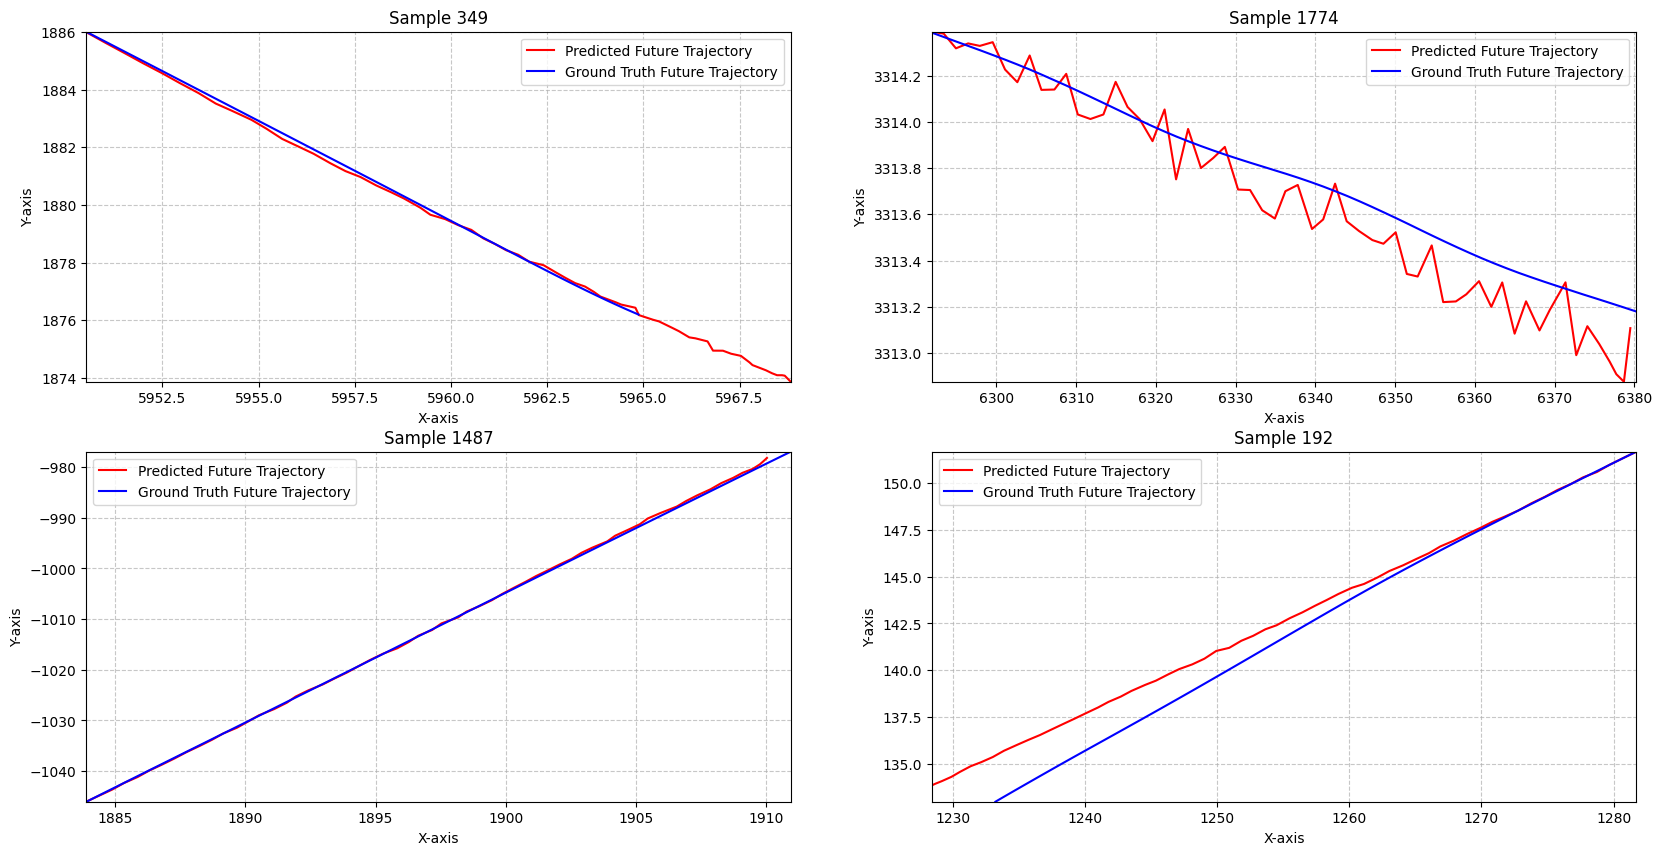

In [212]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [213]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = AdvancedTransformerModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = TransformerModel(
    input_dim=6,
    model_dim=256,
    num_heads=8,
    num_layers=4,
    dropout=0
).to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())

pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B